# Telecom Churn Prediction

**Author:** Chaitanya Murakonda , Omkar Amale


We are going to follow the process called CRISP-DM.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/639px-CRISP-DM_Process_Diagram.png" style="height: 400px; width:400px;"/>

After Business and Data Understanding via EDA, we want to prepare data for modelling. Then evaluate and submit our predictions.

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

### Objective
- To Predict the customers who are about to churn from a telecom operator
- Business Objective is to predict the High Value Customers only
- We need to predict Churn on the basis of Action Period (Churn period data needs to be deleted after labelling) Churn would be based on Usage

### Requirement
- Churn Prediction Model
- Best Predictor Variables

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [5]:
# Data Manipulation
import pandas as pd
import numpy as np
import os
import re

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Sklearn - Model Building and Evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

# Metrics and Evaluation
from sklearn.metrics import (
    accuracy_score, confusion_matrix, precision_score, recall_score, 
    f1_score, roc_auc_score, roc_curve, classification_report, 
    precision_recall_curve
)
from imblearn.metrics import sensitivity_specificity_support

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

# Enable inline plotting for Jupyter Notebooks
%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [6]:
import os
for dirname, _, filenames in os.walk(r'kaggle\input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

kaggle\input\data_dictionary.csv
kaggle\input\sample.csv
kaggle\input\test.csv
kaggle\input\train.csv


In [7]:
data = pd.read_csv(r"kaggle\input\train.csv")
unseen = pd.read_csv(r"kaggle\input\test.csv")
sample = pd.read_csv(r"kaggle\input\sample.csv")
data_dict = pd.read_csv(r"kaggle\input\data_dictionary.csv")

print('Training File Shape ', data.shape)
print('Testing / Unseen File Shape ', unseen.shape)
print('Sample Fie Shape Output Shape ' , sample.shape)
print('Data Dictionary Shape ' , data_dict.shape)

Training File Shape  (69999, 172)
Testing / Unseen File Shape  (30000, 171)
Sample Fie Shape Output Shape  (30000, 2)
Data Dictionary Shape  (36, 2)


1. Lets analyze the data dictionary versus the churn dataset.
2. The data dictonary contains a list of abbrevations which provide you all the information you need to understand what a specific feature/variable in the churn dataset represents
3. Example: 

- "arpu_7" -> Average revenue per user + KPI for the month of July
- "onnet_mou_6" ->  All kind of calls within the same operator network + Minutes of usage voice calls + KPI for the month of June

- "night_pck_user_8" -> Scheme to use during specific night hours only + Prepaid service schemes called PACKS + KPI for the month of August

- "max_rech_data_7" -> Maximum + Recharge + Mobile internet + KPI for the month of July

Its important to understand the definitions of each feature that you are working with, take notes on which feature you think might impact the churn rate of a user, and what sort of analysis could you do to understand the distribution of the feature better.

#### Steps involved

### 1. Data Understanding, Preparation and Pre-Processing.
- Data understanding, identification of potentially useful and non-useful attributes and variable importance and impact estimation
- Data preparation, performing data cleaning, missing values imputation, outlier removal, and column level standardization (for e.g., date, etc.) into one format

### 2. Exploratory Data Analysis
- Performing basic preliminary data analysis including finding the correlation between variables and scatter plots to identify relationships between variables
- Performing advanced data analysis, including plotting relevant heatmaps, histograms, and basic clustering to find patterns in the data

### 3. Feature Engineering and Variable Transformation
- Feature engineering and performing one or more methods on attributes that can lead to the creation of a new potentially useful variable; for e.g., day from the date
- Variable transformation and applying categorical variable transformations to turn into numerical data and numerical variable transformations to scale data

### 4. Model Selection, Model Building, and  Prediction
- Identifying the type of problem and making a list of decisive models from all available choices
- Choosing a training mechanism; for e.g., cross-validation, etc., and tuning hyperparameters of each model
- Testing each model on the respective model evaluation metric
- Choosing the best model based on the fit of the data set and output variable
- Using ensemble options to improve the efficacy based on the evaluation metric stated in the problem

# 2. Data Understanding, Preparation and Pre-Processing.

In [8]:
data_dict

Acronyms                                        Description
0     CIRCLE_ID  Telecom circle area to which the customer belo...
1           LOC            Local calls  within same telecom circle
2           STD              STD calls  outside the calling circle
3            IC                                     Incoming calls
4            OG                                     Outgoing calls
5           T2T  Operator T to T ie within same operator mobile...
6       T2M                    Operator T to other operator mobile
7       T2O                Operator T to other operator fixed line
8       T2F                         Operator T to fixed lines of T
9       T2C                      Operator T to its own call center
10     ARPU                               Average revenue per user
11      MOU                          Minutes of usage  voice calls
12      AON      Age on network  number of days the customer is...
13     ONNET     All kind of calls within the same operator net...
14   OFFNET       All kind of calls outside the operator T network
15         ROAM  Indicates that customer is in roaming zone dur...
16       SPL                                         Special calls
17      ISD                                              ISD calls
18     RECH                                               Recharge
19      NUM                                                 Number
20      AMT                               Amount in local currency
21      MAX                                                Maximum
22     DATA                                        Mobile internet
23       3G                                              G network
24       AV                                                Average
25      VOL                     Mobile internet usage volume in MB
26       2G                                              G network
27      PCK                  Prepaid service schemes called  PACKS
28    NIGHT         Scheme to use during specific night hours only
29  MONTHLY      Service schemes with validity equivalent to a ...
30    SACHET     Service schemes with validity smaller than a m...
31      *.6                              KPI for the month of June
32      *.7                              KPI for the month of July
33      *.8                            KPI for the month of August
34      FB_USER  Service scheme to avail services of Facebook a...
35      VBC      Volume based cost  when no specific scheme is ...

In [9]:
telecom_df = data.copy()
telecom_test_df = unseen.copy()

In [10]:
telecom_df.head()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0   0        109             0.0             0.0             0.0   
1   1        109             0.0             0.0             0.0   
2   2        109             0.0             0.0             0.0   
3   3        109             0.0             0.0             0.0   
4   4        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   31.277   
1            6/30/2014            7/31/2014            8/31/2014    0.000   
2            6/30/2014            7/31/2014            8/31/2014   60.806   
3            6/30/2014            7/31/2014            8/31/2014  156.362   
4            6/30/2014            7/31/2014            8/31/2014  240.708   

    arpu_7  ...  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  fb_user_8  \
0   87.009  ...            0            0        NaN        NaN        NaN   
1  122.787  ...            0            0        NaN        1.0        NaN   
2  103.176  ...            0            0        NaN        NaN        NaN   
3  205.260  ...            0            0        NaN        NaN        NaN   
4  128.191  ...            1            0        1.0        1.0        1.0   

    aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  churn_probability  
0  1958         0.0         0.0         0.0                  0  
1   710         0.0         0.0         0.0                  0  
2   882         0.0         0.0         0.0                  0  
3   982         0.0         0.0         0.0                  0  
4   647         0.0         0.0         0.0                  0  

[5 rows x 172 columns]

In [11]:
pd.DataFrame(telecom_df.columns)

0
0                   id
1            circle_id
2       loc_og_t2o_mou
3       std_og_t2o_mou
4       loc_ic_t2o_mou
..                 ...
167                aon
168         aug_vbc_3g
169         jul_vbc_3g
170         jun_vbc_3g
171  churn_probability

[172 rows x 1 columns]

In [12]:
#Checking the numerical columns data distribution statistics
telecom_df.describe()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count  69999.000000    69999.0         69297.0         69297.0   
mean   34999.000000      109.0             0.0             0.0   
std    20207.115084        0.0             0.0             0.0   
min        0.000000      109.0             0.0             0.0   
25%    17499.500000      109.0             0.0             0.0   
50%    34999.000000      109.0             0.0             0.0   
75%    52498.500000      109.0             0.0             0.0   
max    69998.000000      109.0             0.0             0.0   

       loc_ic_t2o_mou        arpu_6        arpu_7        arpu_8   onnet_mou_6  \
count         69297.0  69999.000000  69999.000000  69999.000000  67231.000000   
mean              0.0    283.134365    278.185912    278.858826    133.153275   
std               0.0    334.213918    344.366927    351.924315    299.963093   
min               0.0  -2258.709000  -1289.715000   -945.808000      0.000000   
25%               0.0     93.581000     86.714000     84.095000      7.410000   
50%               0.0    197.484000    191.588000    192.234000     34.110000   
75%               0.0    370.791000    365.369500    369.909000    119.390000   
max               0.0  27731.088000  35145.834000  33543.624000   7376.710000   

        onnet_mou_7  ...   sachet_3g_7   sachet_3g_8     fb_user_6  \
count  67312.000000  ...  69999.000000  69999.000000  17568.000000   
mean     133.894438  ...      0.081444      0.085487      0.916325   
std      311.277193  ...      0.634547      0.680035      0.276907   
min        0.000000  ...      0.000000      0.000000      0.000000   
25%        6.675000  ...      0.000000      0.000000      1.000000   
50%       32.280000  ...      0.000000      0.000000      1.000000   
75%      115.837500  ...      0.000000      0.000000      1.000000   
max     8157.780000  ...     33.000000     41.000000      1.000000   

          fb_user_7     fb_user_8           aon    aug_vbc_3g    jul_vbc_3g  \
count  17865.000000  18417.000000  69999.000000  69999.000000  69999.000000   
mean       0.909544      0.890319   1220.639709     68.108597     65.935830   
std        0.286842      0.312501    952.426321    269.328659    267.899034   
min        0.000000      0.000000    180.000000      0.000000      0.000000   
25%        1.000000      1.000000    468.000000      0.000000      0.000000   
50%        1.000000      1.000000    868.000000      0.000000      0.000000   
75%        1.000000      1.000000   1813.000000      0.000000      0.000000   
max        1.000000      1.000000   4337.000000  12916.220000   9165.600000   

        jun_vbc_3g  churn_probability  
count  69999.00000       69999.000000  
mean      60.07674           0.101887  
std      257.22681           0.302502  
min        0.00000           0.000000  
25%        0.00000           0.000000  
50%        0.00000           0.000000  
75%        0.00000           0.000000  
max    11166.21000           1.000000  

[8 rows x 163 columns]

In [13]:
telecom_df.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

In [14]:
#Check for the duplicates rows
telecom_df.drop_duplicates(subset=None, inplace=True)
data.shape

(69999, 172)

There are no duplicates in the data.

In [15]:
# Converting the date columns to date time-dataframe

date_column= [column for column in telecom_df.columns if 'date' in column]

for i in telecom_df[date_column]:
    print(i)
    telecom_df[i] = pd.to_datetime(telecom_df[i])

last_date_of_month_6
last_date_of_month_7
last_date_of_month_8
date_of_last_rech_6
date_of_last_rech_7
date_of_last_rech_8
date_of_last_rech_data_6
date_of_last_rech_data_7
date_of_last_rech_data_8


In [16]:
#Dropping Date Columns Actually - Not Required for this use case.
telecom_df = telecom_df.drop(date_column,axis=1)
telecom_df.shape

#Same treatment on Unseen Test data.
telecom_test_df = telecom_test_df.drop(date_column,axis=1)


In [17]:
# Dropping columns with unique values.
columns = []
for i in telecom_df.columns:
    if telecom_df[i].nunique() ==1:
        columns.append(i)
telecom_df = telecom_df.drop(columns,axis=1)

#Dropping same columns from Test Data.
telecom_test_df = telecom_test_df.drop(columns,axis=1)

In [18]:
telecom_df.head()

id   arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0   0   31.277   87.009    7.527        48.58       124.38         1.29   
1   1    0.000  122.787   42.953         0.00         0.00         0.00   
2   2   60.806  103.176    0.000         0.53        15.93         0.00   
3   3  156.362  205.260  111.095         7.26        16.01         0.00   
4   4  240.708  128.191  101.565        21.28         4.83         6.13   

   offnet_mou_6  offnet_mou_7  offnet_mou_8  ...  sachet_3g_7  sachet_3g_8  \
0         32.24         96.68          2.33  ...            0            0   
1          0.00         25.99         30.89  ...            0            0   
2         53.99         82.05          0.00  ...            0            0   
3         68.76         78.48         50.23  ...            0            0   
4         56.99         38.11          9.63  ...            1            0   

   fb_user_6  fb_user_7  fb_user_8   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  \
0        NaN        NaN        NaN  1958         0.0         0.0         0.0   
1        NaN        1.0        NaN   710         0.0         0.0         0.0   
2        NaN        NaN        NaN   882         0.0         0.0         0.0   
3        NaN        NaN        NaN   982         0.0         0.0         0.0   
4        1.0        1.0        1.0   647         0.0         0.0         0.0   

   churn_probability  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  

[5 rows x 153 columns]

In [19]:
telecom_df.shape

(69999, 153)

In [20]:
# Remove the id column since it is unique for every row from the training set
telecom_df.drop('id', axis=1, inplace=True)

In [21]:
# Let us create a seperate category for categorical columns
categorical_columns = ['night_pck_user_6',
            'night_pck_user_7',
            'night_pck_user_8',
            'fb_user_6',
            'fb_user_7',
            'fb_user_8',
           ]

numerical_cols = [col for col in telecom_df.columns if col not in categorical_columns]

In [22]:
# Now Checking Null values
null = round(100*(telecom_df.isnull().sum()/len(telecom_df.index)),2).sort_values(ascending = False)
null = null[null!=0]
null

fb_user_6             74.90
count_rech_3g_6       74.90
count_rech_2g_6       74.90
max_rech_data_6       74.90
av_rech_amt_data_6    74.90
                      ...  
std_ic_t2m_mou_7       3.84
ic_others_7            3.84
std_og_t2t_mou_7       3.84
loc_og_mou_7           3.84
loc_ic_t2m_mou_7       3.84
Length: 108, dtype: float64

There are numerous variables with consistent percentages of missing data, suggesting a pattern of *meaningful* absence.

So, Let's focus on this,

1. Grouping and treating missing values for 'recharge-related' data.
2. Grouping and treating missing values for 'ARPU' data.
3. Conducting missing value treatment on categorical columns.

# 3. EDA , Feature Engineering

#### Recharge Columns


In [23]:
# Columns with recharge information
recharge_cols = telecom_df.columns[telecom_df.columns.str.contains('_rech_')]
print(recharge_cols)

Index(['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8',
       'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8',
       'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
       'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8',
       'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8',
       'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8'],
      dtype='object')


In [24]:
#Let's check the pattern,
telecom_df[telecom_df["total_rech_data_6"].isna()][["total_rech_data_6","max_rech_data_6","av_rech_amt_data_6","total_rech_num_6","total_rech_amt_6","max_rech_amt_6","count_rech_2g_6","count_rech_3g_6"]]


total_rech_data_6  max_rech_data_6  av_rech_amt_data_6  \
0                    NaN              NaN                 NaN   
1                    NaN              NaN                 NaN   
2                    NaN              NaN                 NaN   
3                    NaN              NaN                 NaN   
5                    NaN              NaN                 NaN   
...                  ...              ...                 ...   
69991                NaN              NaN                 NaN   
69992                NaN              NaN                 NaN   
69994                NaN              NaN                 NaN   
69995                NaN              NaN                 NaN   
69996                NaN              NaN                 NaN   

       total_rech_num_6  total_rech_amt_6  max_rech_amt_6  count_rech_2g_6  \
0                     3                77              65              NaN   
1                     3                 0               0              NaN   
2                     2                70              70              NaN   
3                     2               160             110              NaN   
5                     9               100              30              NaN   
...                 ...               ...             ...              ...   
69991                 2                 0               0              NaN   
69992                11                80              10              NaN   
69994                 1                50              50              NaN   
69995                 5               200              90              NaN   
69996                 3               626             279              NaN   

       count_rech_3g_6  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
5                  NaN  
...                ...  
69991              NaN  
69992              NaN  
69994              NaN  
69995              NaN  
69996              NaN  

[52431 rows x 8 columns]

In [25]:
#Let's check the pattern,
telecom_df[telecom_df["total_rech_data_7"].isna()].isna()[["total_rech_data_7","max_rech_data_7","max_rech_data_7","av_rech_amt_data_7"]]

total_rech_data_7  max_rech_data_7  max_rech_data_7  av_rech_amt_data_7
0                   True             True             True                True
2                   True             True             True                True
3                   True             True             True                True
5                   True             True             True                True
6                   True             True             True                True
...                  ...              ...              ...                 ...
69991               True             True             True                True
69992               True             True             True                True
69995               True             True             True                True
69996               True             True             True                True
69998               True             True             True                True

[52134 rows x 4 columns]

In [26]:
#Let's check the pattern,
telecom_df[telecom_df["total_rech_data_8"].isna()].isna()[["total_rech_data_8","max_rech_data_8","max_rech_data_8","av_rech_amt_data_8"]]

total_rech_data_8  max_rech_data_8  max_rech_data_8  av_rech_amt_data_8
0                   True             True             True                True
1                   True             True             True                True
2                   True             True             True                True
3                   True             True             True                True
5                   True             True             True                True
...                  ...              ...              ...                 ...
69991               True             True             True                True
69992               True             True             True                True
69993               True             True             True                True
69995               True             True             True                True
69996               True             True             True                True

[51582 rows x 4 columns]

Pattern clearly says total recharge is empty then all individual recharge are also empty. We can impute those as 0.

In [27]:
# Replacing NaN values in recharge related columns with 0 in the training set
telecom_df[recharge_cols] = telecom_df[recharge_cols].fillna(0)

In [28]:
# Now Checking Null values in Recharge Columns.
null = round(100*(telecom_df[recharge_cols].isnull().sum()/len(telecom_df.index)),2).sort_values(ascending = False)
null = null[null!=0]
null

Series([], dtype: float64)

In [29]:
#Apply the same to the unseen test data.
telecom_test_df[recharge_cols] = telecom_test_df[recharge_cols].fillna(0)

#### ARPU Columns

In [30]:
# Columns with 'arpu'in labels. Average Revenue Per User.
arpu_cols = telecom_df.columns[telecom_df.columns.str.contains('arpu_')]
print(arpu_cols)

Index(['arpu_6', 'arpu_7', 'arpu_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
       'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8'],
      dtype='object')


In [31]:
telecom_df[telecom_df["arpu_3g_7"].isna()][["arpu_3g_7","arpu_7","arpu_2g_7"]]

arpu_3g_7   arpu_7  arpu_2g_7
0            NaN   87.009        NaN
2            NaN  103.176        NaN
3            NaN  205.260        NaN
5            NaN   83.351        NaN
6            NaN   95.130        NaN
...          ...      ...        ...
69991        NaN  139.385        NaN
69992        NaN   27.362        NaN
69995        NaN  289.129        NaN
69996        NaN  258.374        NaN
69998        NaN   42.815        NaN

[52134 rows x 3 columns]

In [32]:
# Replacing NaN values in ARPU related columns with 0 in the training set
telecom_df[arpu_cols] = telecom_df[arpu_cols].fillna(0)

In [33]:
#Apply the same on Unseen data
telecom_test_df[arpu_cols] = telecom_test_df[arpu_cols].fillna(0)

Let's perorm on Categorical columns

In [34]:
telecom_df[categorical_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   night_pck_user_6  17568 non-null  float64
 1   night_pck_user_7  17865 non-null  float64
 2   night_pck_user_8  18417 non-null  float64
 3   fb_user_6         17568 non-null  float64
 4   fb_user_7         17865 non-null  float64
 5   fb_user_8         18417 non-null  float64
dtypes: float64(6)
memory usage: 3.2 MB


1. Replace NaN values with -1 in the categorical columns of the test set.
2. The columns in cat_cols are currently of float64 type.
3. Convert these columns to the category data type before applying the changes.

In [35]:
#Applying to both the data, train and unseen data.
telecom_df[categorical_columns] = telecom_df[categorical_columns].fillna(-1).astype('category')
telecom_test_df[categorical_columns] = telecom_test_df[categorical_columns].fillna(-1).astype('category')

In [36]:
telecom_df.shape

(69999, 152)

In [37]:
telecom_df[categorical_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   night_pck_user_6  69999 non-null  category
 1   night_pck_user_7  69999 non-null  category
 2   night_pck_user_8  69999 non-null  category
 3   fb_user_6         69999 non-null  category
 4   fb_user_7         69999 non-null  category
 5   fb_user_8         69999 non-null  category
dtypes: category(6)
memory usage: 411.1 KB


In [38]:
# missing value ratio
telecom_df[categorical_columns].isnull().sum()*100/data.shape[0]

night_pck_user_6    0.0
night_pck_user_7    0.0
night_pck_user_8    0.0
fb_user_6           0.0
fb_user_7           0.0
fb_user_8           0.0
dtype: float64

In [39]:
# Now Checking Null values
null = round(100*(telecom_df.isnull().sum()/len(telecom_df.index)),2).sort_values(ascending = False)
null = null[null!=0]
null

onnet_mou_8         5.29
roam_og_mou_8       5.29
loc_og_t2f_mou_8    5.29
loc_og_t2m_mou_8    5.29
loc_og_t2t_mou_8    5.29
                    ... 
loc_ic_t2m_mou_7    3.84
std_ic_t2t_mou_7    3.84
loc_ic_mou_7        3.84
loc_ic_t2f_mou_7    3.84
spl_og_mou_7        3.84
Length: 81, dtype: float64

In [40]:
miss_col = null.index.tolist()

In [41]:
miss_col

['onnet_mou_8',
 'roam_og_mou_8',
 'loc_og_t2f_mou_8',
 'loc_og_t2m_mou_8',
 'loc_og_t2t_mou_8',
 'offnet_mou_8',
 'roam_ic_mou_8',
 'std_ic_t2f_mou_8',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_8',
 'loc_ic_t2f_mou_8',
 'loc_ic_mou_8',
 'std_ic_t2t_mou_8',
 'std_ic_t2m_mou_8',
 'std_ic_mou_8',
 'og_others_8',
 'std_og_mou_8',
 'isd_og_mou_8',
 'spl_og_mou_8',
 'std_og_t2f_mou_8',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_8',
 'loc_og_mou_8',
 'loc_og_t2c_mou_8',
 'isd_ic_mou_8',
 'spl_ic_mou_8',
 'ic_others_8',
 'ic_others_6',
 'loc_ic_mou_6',
 'std_ic_t2t_mou_6',
 'loc_ic_t2m_mou_6',
 'loc_og_t2c_mou_6',
 'og_others_6',
 'std_og_t2f_mou_6',
 'offnet_mou_6',
 'loc_og_t2t_mou_6',
 'roam_ic_mou_6',
 'roam_og_mou_6',
 'loc_og_t2m_mou_6',
 'loc_og_t2f_mou_6',
 'onnet_mou_6',
 'isd_ic_mou_6',
 'std_ic_mou_6',
 'std_ic_t2f_mou_6',
 'spl_ic_mou_6',
 'loc_ic_t2f_mou_6',
 'isd_og_mou_6',
 'loc_ic_t2t_mou_6',
 'std_og_mou_6',
 'std_og_t2t_mou_6',
 'std_og_t2m_mou_6',
 'spl_og_mou_6',
 'loc_og_mou_6',
 

### Deriving new features - High Value Customers Identification

### Filter high-value customers

- we can take good phase ( it means month 6 and 7) data to get high value customers, We can use 70th percentile recharge amount ( The ones who have recharged above amount X, X is 70th Percentile)

In this segment, we'll identify high-value customers aligning with our business objectives, focusing solely on prepaid customers experiencing usage-based churn. We'll evaluate the recharge amounts for June and July, selecting only the top 70% (This is assumption) of customers as high-value.

We can create a new feature named ***Total Data Recharge Amount*** by multiplying the values of `total_rech_data` and `av_rech_amt_data`, which represents the amount recharged by the customer for data usage.

- ***Total Data Recharge Amount = Total Data Recharge * Average Data Recharge Amount***

Created another column for total recharge done ***Total Amount*** for the months 6 and 7.

- ***Total Amount = Total Data Recharge Amount + Total Recharge Amount***

Additionally, we can compute the ***Total Average Recharge Amount*** during the 'Good Phase', which includes months 6 and 7.

- ***Total Average Amount = (Total Data Recharge Amount + Total Recharge Amount) / 2***

In [42]:
# Deriving new columns for Total Data Recharge Amount for the 'Good Phase' in the training set
telecom_df['total_rech_data_amt_6'] = telecom_df['total_rech_data_6'] * telecom_df['av_rech_amt_data_6']
telecom_df['total_rech_data_amt_7'] = telecom_df['total_rech_data_7'] * telecom_df['av_rech_amt_data_7']

telecom_df['total_amt_6'] = telecom_df['total_rech_data_amt_6'] + telecom_df['total_rech_amt_6']
telecom_df['total_amt_7'] = telecom_df['total_rech_data_amt_7'] + telecom_df['total_rech_amt_7']

telecom_df['total_avg_amt_6_7'] = telecom_df[['total_amt_6', 'total_amt_7']].mean(axis=1)

In [43]:
# Dropping the columns as they are not so useful columns for high value customer or churn

drop_data_cols = ['total_rech_data_amt_6', 'total_rech_data_amt_7', 'av_rech_amt_data_6', 'av_rech_amt_data_7',
                  'av_rech_amt_data_8', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',]

telecom_df.drop(drop_data_cols, axis=1, inplace=True)

In [44]:
# Deriving new columns for Total Data Recharge Amount for the 'Good Phase' in the test set
telecom_test_df['total_rech_data_amt_6'] = telecom_test_df['total_rech_data_6'] * telecom_test_df['av_rech_amt_data_6']
telecom_test_df['total_rech_data_amt_7'] = telecom_test_df['total_rech_data_7'] * telecom_test_df['av_rech_amt_data_7']

telecom_test_df['total_amt_6'] = telecom_test_df['total_rech_data_amt_6'] + telecom_test_df['total_rech_amt_6']
telecom_test_df['total_amt_7'] = telecom_test_df['total_rech_data_amt_7'] + telecom_test_df['total_rech_amt_7']

telecom_test_df['total_avg_amt_6_7'] = telecom_test_df[['total_amt_6', 'total_amt_7']].mean(axis=1)

# Dropping the drop_data_cols from the test set
telecom_test_df.drop(drop_data_cols, axis=1, inplace=True)

In [45]:
# Checking for any null value in the derived column in the training set
telecom_df['total_avg_amt_6_7'].isnull().sum()

np.int64(0)

In [46]:
print(telecom_df.shape)
print(telecom_test_df.shape)

(69999, 149)
(30000, 149)


### Assumption - No clarity is provided on what percentile to be considered for high value customers but as per the industry standard taking 70. This is the assumption.

In [47]:
cutoff_percentage = telecom_df['total_avg_amt_6_7'].dropna().quantile(0.7)
cutoff_percentage

np.float64(477.5)

In [48]:
# look at the 70th percentile recharge amount
print("Recharge amount at 70th percentile: {0}".format(telecom_df.total_avg_amt_6_7.quantile(0.7)))

Recharge amount at 70th percentile: 477.5


In [49]:
# Segregating high value customers
# Filter high value customers in the new dataframe (high_val_train) where total recharge is more than 477.5
high_val_customers_train = telecom_df[(telecom_df['total_avg_amt_6_7'] > cutoff_percentage)].copy()

print(high_val_customers_train.shape)

(20998, 149)


In [50]:
high_val_customers_train.shape

(20998, 149)

### "Churn_Probability" is given, we will check based on month 8 data.

- We didn't get target variable, we have to derive target variable.
- We have month 8 data columns to derive - 'total_ic_mou_8','total_og_mou_8','vol_2g_mb_8','vol_3g_mb_8'

In [51]:
high_val_customers_train['churn_probability'].dtype

dtype('int64')

In [52]:
high_val_customers_train['churn_probability'] = high_val_customers_train['churn_probability'].astype('category')

This step is important as we don't want to scale such features in numeric columns. And since this is classification feature we should keep it as Category.

In [53]:
# Check the value counts of churn and not-churn
print(high_val_customers_train['churn_probability'].value_counts())

print('-------------------------------------------------')

# Calculate churn ratio
print('Churn ratio:')
print(high_val_customers_train['churn_probability'].value_counts()*100/high_val_customers_train.shape[0])

churn_probability
0    19263
1     1735
Name: count, dtype: int64
-------------------------------------------------
Churn ratio:
churn_probability
0    91.737308
1     8.262692
Name: count, dtype: float64


In [54]:
print("The Percentage of churned customers is:" , round(100*(high_val_customers_train.churn_probability.astype("int").sum()/len(high_val_customers_train)),2))

The Percentage of churned customers is: 8.26


#### We can infer from this, 91.7 % customers do not churn. It seems like huge class imbalance in the data.

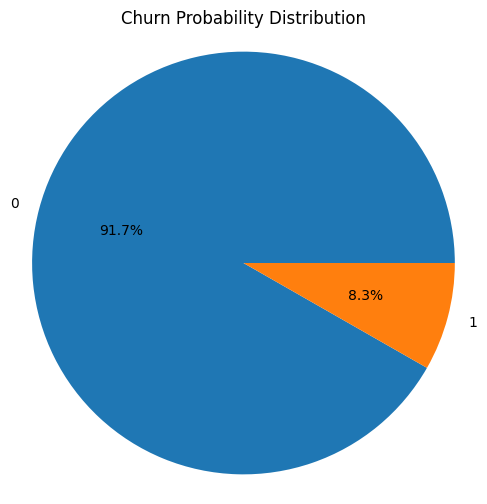

In [55]:
# Step 1: Get value counts and calculate percentage
value_counts = high_val_customers_train['churn_probability'].value_counts()
percentage = (value_counts / len(high_val_customers_train)) * 100

# Step 2: Plot the pie chart
plt.figure(figsize=(6, 6))
plt.pie(percentage, labels=percentage.index, autopct='%1.1f%%')
plt.title("Churn Probability Distribution")
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is a circle.
plt.show()

#### Clearly class imbalance treatment is required.

In [56]:
#Create a copy of high_val_train df and use the new df (churn_data) for pruning in the training set
churn_data = high_val_customers_train.copy()
churn_data.reset_index(inplace=True)
churn_data.drop(['index'], axis=1, inplace=True)

In [57]:
# Now Checking Null values
null = round(100*(churn_data.isnull().sum()/len(churn_data.index)),2).sort_values(ascending = False)
null = null[null!=0]
null

loc_og_t2t_mou_8    3.91
roam_og_mou_8       3.91
roam_ic_mou_8       3.91
offnet_mou_8        3.91
onnet_mou_8         3.91
                    ... 
loc_ic_mou_7        1.87
isd_ic_mou_7        1.87
std_og_t2f_mou_7    1.87
std_og_t2m_mou_7    1.87
ic_others_7         1.87
Length: 81, dtype: float64

In [58]:
len(null)

81

In [59]:
null_colns=null.index.tolist()

### Impute missing values using KNN Imputer - Training Set

We cannot discard these missing values because doing so would result in the loss of valuable information. Instead, we will employ imputation techniques such as KNNImputer.

KNNImputer is a technique used to impute missing values in a dataset based on the values of its nearest neighbors. It works by identifying the k nearest neighbors of each data point with missing values, then averaging or taking a weighted average of the available values from those neighbors to fill in the missing value. This approach leverages the similarity between data points to estimate the missing values more accurately.

In [60]:
# Create imputer instance
imputer = KNNImputer(n_neighbors=5)

In [61]:
# Separate df having columns to be imputed
df_num = churn_data[null_colns]
churn_df = churn_data.drop(null_colns, axis=1)

In [62]:
churn_df

arpu_6    arpu_7    arpu_8  total_og_mou_6  total_og_mou_7  \
0       240.708   128.191   101.565           63.26           42.94   
1       580.549   377.294   338.286          327.64          366.79   
2      1130.948   905.506   479.762         1152.99          822.83   
3       371.974   352.069   240.449          624.38          546.06   
4       390.489   350.985   421.300          141.74          170.21   
...         ...       ...       ...             ...             ...   
20993  1106.130  1609.381  1686.392          916.79          797.13   
20994   196.695   298.645   192.440           47.99           32.16   
20995   235.524   195.633   129.598          156.81          332.46   
20996    15.760   410.924   329.136            0.00          496.68   
20997   238.575   245.414   145.062           39.78           24.33   

       total_og_mou_8  total_ic_mou_6  total_ic_mou_7  total_ic_mou_8  \
0               15.76           21.54            9.36           28.31   
1              391.53          233.18          777.39          629.94   
2              387.81          598.54          448.36          203.29   
3              251.89          230.08          155.64          192.94   
4              195.51          283.48          366.03          350.86   
...               ...             ...             ...             ...   
20993          915.38          343.16          274.94          318.86   
20994           36.76          102.61           34.74           63.98   
20995            0.00           37.38          173.63            7.55   
20996          392.58            0.00          221.99          269.56   
20997           19.28           18.83           16.24           17.76   

       total_rech_num_6  ...  fb_user_7  fb_user_8   aon  aug_vbc_3g  \
0                    13  ...        1.0        1.0   647        0.00   
1                     5  ...       -1.0        1.0   602        0.00   
2                    26  ...       -1.0       -1.0   455        0.00   
3                     7  ...        0.0        0.0  1219        0.00   
4                    13  ...        1.0        1.0   573      700.40   
...                 ...  ...        ...        ...   ...         ...   
20993                 5  ...       -1.0       -1.0   283        6.48   
20994                 7  ...        1.0        1.0   251      107.77   
20995                19  ...        1.0       -1.0  1507        0.00   
20996                 1  ...        1.0        1.0   221        0.00   
20997                 5  ...        1.0        1.0   277      664.25   

       jul_vbc_3g  jun_vbc_3g  churn_probability  total_amt_6  total_amt_7  \
0            0.00        0.00                  0       1515.0       1473.0   
1            0.00        0.00                  0        808.0        400.0   
2            0.00        0.00                  0       1420.0        990.0   
3            0.00        0.00                  0        463.0        519.0   
4          185.71      173.72                  0       1385.0       1180.0   
...           ...         ...                ...          ...          ...   
20993      102.80      127.41                  0       3243.0        900.0   
20994      112.70      242.18                  0        449.0       1074.0   
20995       16.53       18.84                  0       3118.0        306.0   
20996        0.00        0.00                  0         50.0       1342.0   
20997     1402.96      990.97                  0        558.0        504.0   

       total_avg_amt_6_7  
0                 1494.0  
1                  604.0  
2                 1205.0  
3                  491.0  
4                 1282.5  
...                  ...  
20993             2071.5  
20994              761.5  
20995             1712.0  
20996              696.0  
20997              531.0  

[20998 rows x 68 columns]

In [63]:
%%time
# Impute using KNN imputer instance
df_imp = imputer.fit_transform(df_num)

CPU times: total: 46.5 s
Wall time: 54.4 s


In [64]:
# Convert it to df post imputation
df_imp = pd.DataFrame(df_imp, columns=null_colns)
df_imp.head()

loc_og_t2t_mou_8  roam_og_mou_8  roam_ic_mou_8  offnet_mou_8  onnet_mou_8  \
0              6.13            0.0            0.0          9.63         6.13   
1            194.43            0.0            0.0        197.09       194.43   
2              0.89            0.0            0.0        386.91         0.89   
3             29.86            0.0            0.0        222.03        29.86   
4             12.68            0.0            0.0        182.83        12.68   

   loc_og_t2m_mou_8  loc_ic_t2m_mou_8  loc_ic_mou_8  loc_ic_t2f_mou_8  \
0              4.61             19.49         28.31              6.14   
1            185.88            285.63        629.94              8.88   
2            378.01            148.83        202.89             23.66   
3             99.86            150.73        171.01              1.13   
4            157.23            159.69        350.46            107.94   

   std_ic_t2t_mou_8  ...  isd_og_mou_7  std_ic_t2t_mou_7  loc_ic_t2m_mou_7  \
0               0.0  ...           0.0               0.0              4.33   
1               0.0  ...           0.0               0.0            754.24   
2               0.0  ...           0.0               0.0            278.49   
3               0.0  ...           0.0               0.0            106.71   
4               0.4  ...           0.0               0.0            214.49   

   loc_ic_t2t_mou_7  loc_ic_t2f_mou_7  loc_ic_mou_7  isd_ic_mou_7  \
0              1.39              3.63          9.36           0.0   
1             20.18              1.93        776.36           0.0   
2            117.63             52.08        448.21           0.0   
3             37.84              1.53        146.09           0.0   
4             83.83             67.69        366.03           0.0   

   std_og_t2f_mou_7  std_og_t2m_mou_7  ic_others_7  
0               0.0              0.00         0.00  
1               0.0              0.00         0.00  
2               0.0              0.00         0.15  
3               0.0            288.31         0.00  
4               0.0              0.00         0.00  

[5 rows x 81 columns]

In [65]:
# Merge the two dataframes together post imputation to create the final training set
final_df = pd.concat([df_imp, churn_df], join='inner', axis=1)
final_df.head()

loc_og_t2t_mou_8  roam_og_mou_8  roam_ic_mou_8  offnet_mou_8  onnet_mou_8  \
0              6.13            0.0            0.0          9.63         6.13   
1            194.43            0.0            0.0        197.09       194.43   
2              0.89            0.0            0.0        386.91         0.89   
3             29.86            0.0            0.0        222.03        29.86   
4             12.68            0.0            0.0        182.83        12.68   

   loc_og_t2m_mou_8  loc_ic_t2m_mou_8  loc_ic_mou_8  loc_ic_t2f_mou_8  \
0              4.61             19.49         28.31              6.14   
1            185.88            285.63        629.94              8.88   
2            378.01            148.83        202.89             23.66   
3             99.86            150.73        171.01              1.13   
4            157.23            159.69        350.46            107.94   

   std_ic_t2t_mou_8  ...  fb_user_7  fb_user_8   aon  aug_vbc_3g  jul_vbc_3g  \
0               0.0  ...        1.0        1.0   647         0.0        0.00   
1               0.0  ...       -1.0        1.0   602         0.0        0.00   
2               0.0  ...       -1.0       -1.0   455         0.0        0.00   
3               0.0  ...        0.0        0.0  1219         0.0        0.00   
4               0.4  ...        1.0        1.0   573       700.4      185.71   

   jun_vbc_3g  churn_probability  total_amt_6  total_amt_7  total_avg_amt_6_7  
0        0.00                  0       1515.0       1473.0             1494.0  
1        0.00                  0        808.0        400.0              604.0  
2        0.00                  0       1420.0        990.0             1205.0  
3        0.00                  0        463.0        519.0              491.0  
4      173.72                  0       1385.0       1180.0             1282.5  

[5 rows x 149 columns]

In [66]:
final_df.shape

(20998, 149)

In [67]:
# Now Checking Null values
null = round(100*(final_df.isnull().sum()/len(final_df.index)),2).sort_values(ascending = False)
null = null[null!=0]
null

Series([], dtype: float64)

In [68]:
#Let's apply imputer on unseen data as well.
df_num_unseen = telecom_test_df[null_colns]
churn_df_unseen = telecom_test_df.drop(null_colns, axis=1)

In [69]:
%%time
# Impute using KNN imputer instance
df_imp_unseen = imputer.transform(df_num_unseen)

CPU times: total: 1min 57s
Wall time: 2min 4s


In [70]:
# Convert it to df post imputation
df_imp_unseen = pd.DataFrame(df_imp_unseen, columns=null_colns)
df_imp_unseen.head()

loc_og_t2t_mou_8  roam_og_mou_8  roam_ic_mou_8  offnet_mou_8  onnet_mou_8  \
0             21.06           0.00           0.00         34.83        23.11   
1             19.84           0.00           0.00        394.94        19.84   
2              0.00          54.44          26.08         45.04         8.40   
3              0.00           0.00           0.00         24.01         0.00   
4             14.56           0.00           0.00         74.16       700.68   

   loc_og_t2m_mou_8  loc_ic_t2m_mou_8  loc_ic_mou_8  loc_ic_t2f_mou_8  \
0              8.36              9.53         31.51              0.00   
1            377.26            184.81        187.43              0.00   
2              0.00              0.00          0.00              0.00   
3             20.51            506.94        531.64              1.64   
4             10.94              7.69         17.61              0.00   

   std_ic_t2t_mou_8  ...  isd_og_mou_7  std_ic_t2t_mou_7  loc_ic_t2m_mou_7  \
0              0.00  ...           0.0              0.00              4.59   
1              0.00  ...           0.0              0.00            122.29   
2              0.00  ...           0.0              0.00              0.00   
3              0.00  ...           0.0              4.26            449.83   
4            107.39  ...           0.0             92.36              9.23   

   loc_ic_t2t_mou_7  loc_ic_t2f_mou_7  loc_ic_mou_7  isd_ic_mou_7  \
0             37.56              0.00         42.16          0.00   
1             26.95              0.00        149.24        177.88   
2              0.00              0.00          0.00          0.00   
3             54.64              0.38        504.86          1.43   
4              0.36              0.00          9.59          0.00   

   std_og_t2f_mou_7  std_og_t2m_mou_7  ic_others_7  
0               0.0              7.68          0.0  
1               0.0             23.76          0.0  
2               0.0              0.00          0.0  
3               0.0             94.36          0.0  
4               0.0             21.18          0.0  

[5 rows x 81 columns]

In [71]:
# Merge the two dataframes together post imputation
final_unseen_df = pd.concat([df_imp_unseen, churn_df_unseen], join='inner', axis=1)
final_unseen_df.head()

loc_og_t2t_mou_8  roam_og_mou_8  roam_ic_mou_8  offnet_mou_8  onnet_mou_8  \
0             21.06           0.00           0.00         34.83        23.11   
1             19.84           0.00           0.00        394.94        19.84   
2              0.00          54.44          26.08         45.04         8.40   
3              0.00           0.00           0.00         24.01         0.00   
4             14.56           0.00           0.00         74.16       700.68   

   loc_og_t2m_mou_8  loc_ic_t2m_mou_8  loc_ic_mou_8  loc_ic_t2f_mou_8  \
0              8.36              9.53         31.51              0.00   
1            377.26            184.81        187.43              0.00   
2              0.00              0.00          0.00              0.00   
3             20.51            506.94        531.64              1.64   
4             10.94              7.69         17.61              0.00   

   std_ic_t2t_mou_8  ...  fb_user_6  fb_user_7  fb_user_8   aon  aug_vbc_3g  \
0              0.00  ...       -1.0       -1.0       -1.0  1692        0.00   
1              0.00  ...       -1.0       -1.0       -1.0  2533        0.00   
2              0.00  ...       -1.0       -1.0       -1.0   277      525.61   
3              0.00  ...       -1.0       -1.0       -1.0  1244        0.00   
4            107.39  ...       -1.0       -1.0       -1.0   462        0.00   

   jul_vbc_3g  jun_vbc_3g  total_amt_6  total_amt_7  total_avg_amt_6_7  
0        0.00        0.00        103.0         90.0               96.5  
1        0.00        0.00        500.0        500.0              500.0  
2      758.41      241.84        500.0       1000.0              750.0  
3        0.00        0.00        110.0        260.0              185.0  
4        0.00        0.00        356.0        490.0              423.0  

[5 rows x 149 columns]

In [72]:
final_unseen_df.shape

(30000, 149)

### Now, No missing values in the data set.

Let's perform EDA.

In [73]:
def plot_bar_graph(title, month, y_list, data):
    """
    Plot bar graphs for given data.

    Parameters:
    - title (str): Title of the plot.
    - month (list of str): List of month names.
    - y_list (list of str): List of y-variable names corresponding to each month.
    - data (DataFrame): DataFrame containing the data to be plotted.

    Returns:
    - None

    This function plots bar graphs for each month's data based on the provided y-variables.
    It creates subplots for each month, with the corresponding y-variable plotted against 'churn_probability'.
    The title of each subplot includes the specified title along with the month name.
    """
    plt.figure(figsize=(15, 10))

    for i, m in enumerate(month):
        plt.subplot(2, 3, i+1)
        plt.title(f'{title} for {m}')
        sns.barplot(x='churn_probability', y=y_list[i], data=data,palette="tab10")

    plt.tight_layout()
    plt.show()

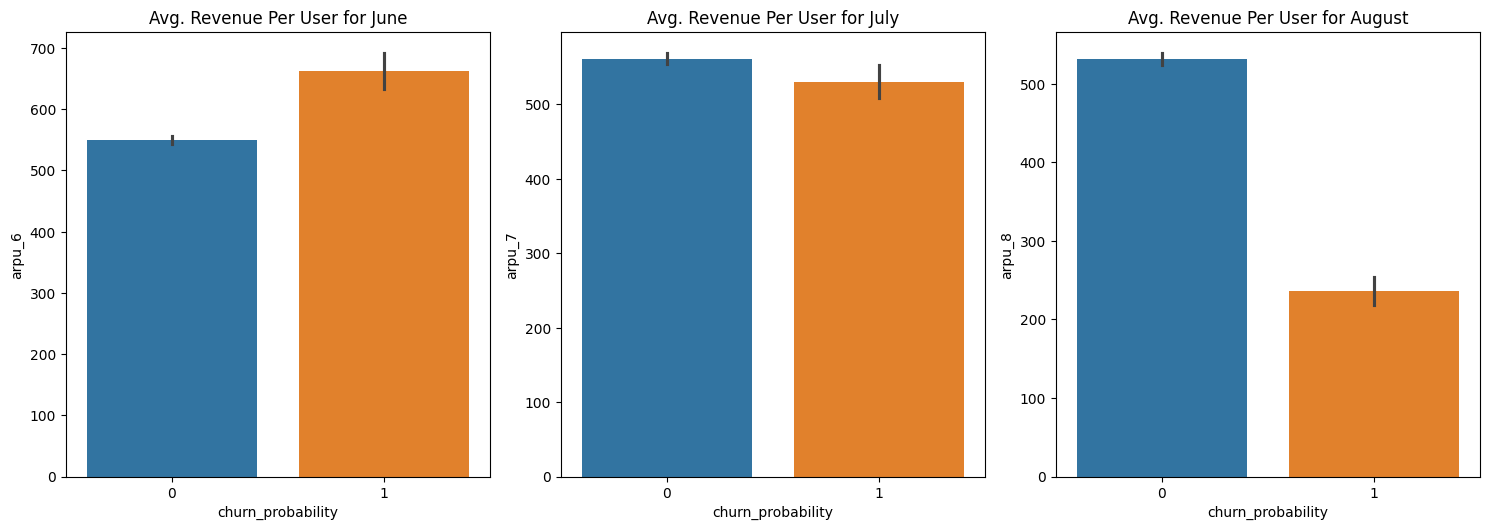

In [74]:
arpu_cols = ['arpu_6', 'arpu_7', 'arpu_8']
plot_bar_graph('Avg. Revenue Per User', ['June', 'July', 'August'], arpu_cols, final_df)

Avg Revenue is declining in August, means indicator of Churn.

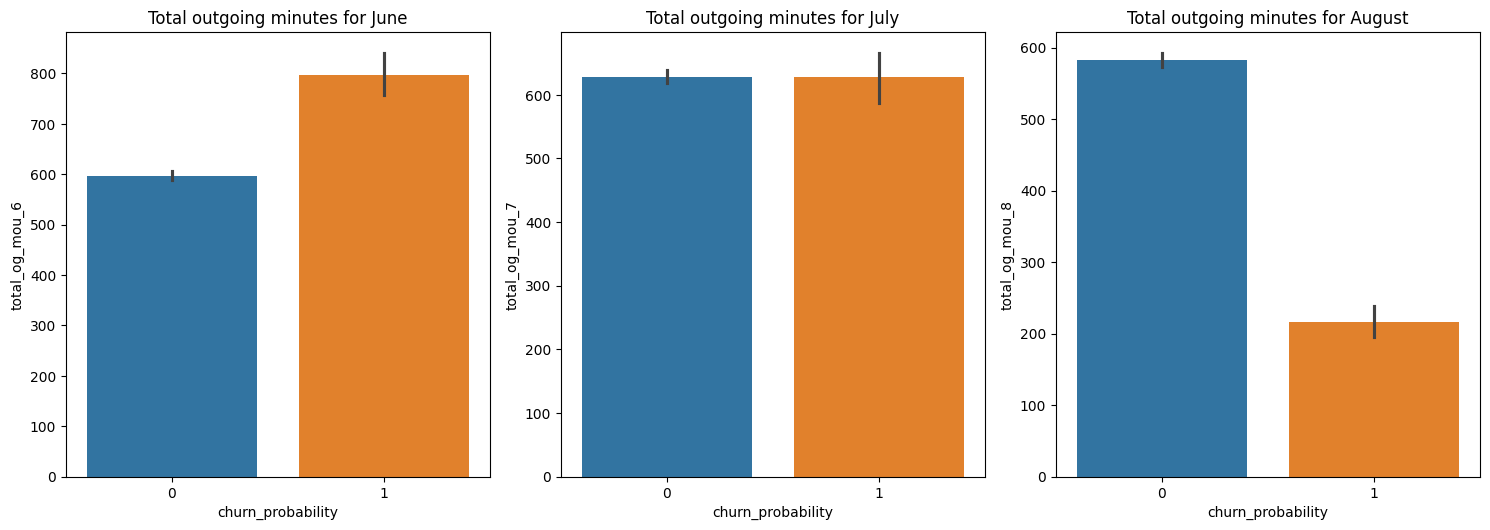

In [75]:
# Visualising Outgoing minutes of usage
total_og_mou_cols = ['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']
plot_bar_graph('Total outgoing minutes', ['June', 'July', 'August'], total_og_mou_cols, final_df)

In the month of August its declining, suggest churn.

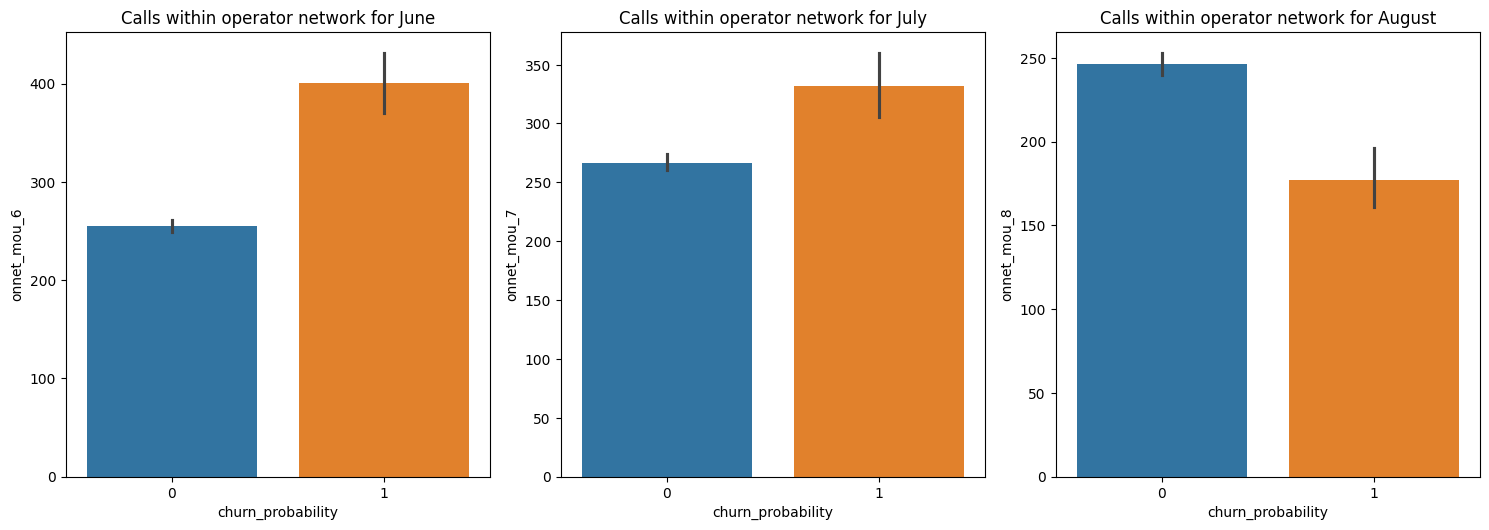

In [76]:
# Visualizing all types of calls within the operator's network.
onnet_mou_cols = ['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8']
plot_bar_graph('Calls within operator network', ['June', 'July', 'August'], onnet_mou_cols, final_df)

August again Calls within operator network is declining.

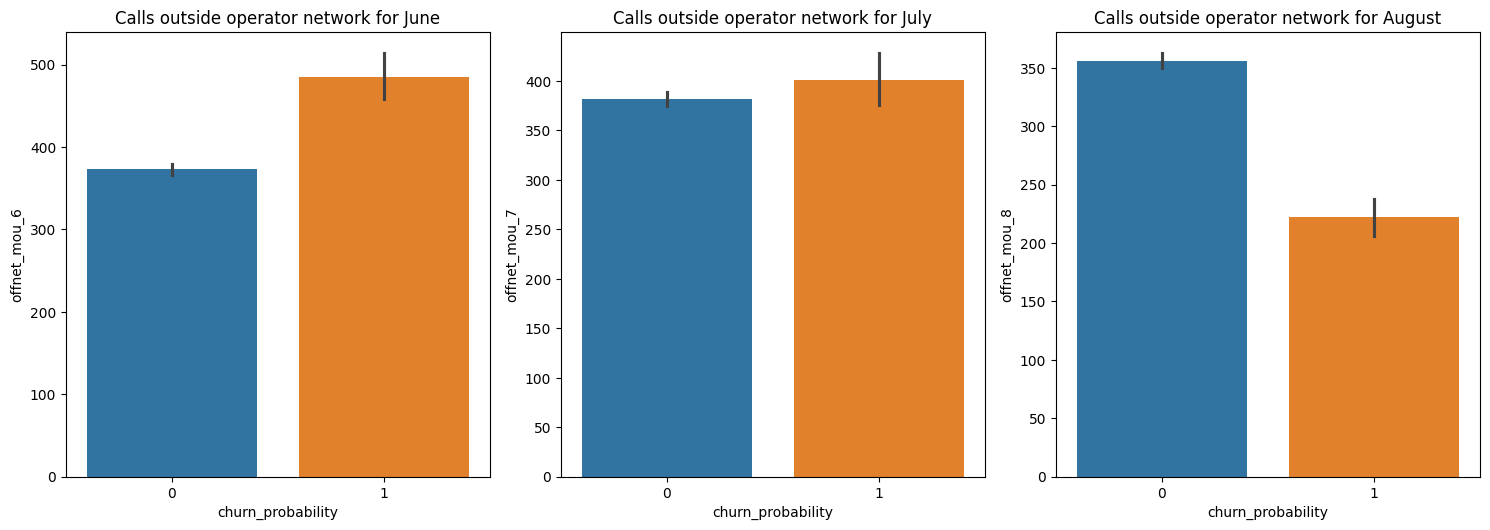

In [77]:
# Visualizing all types of calls made outside the operator network.
offnet_mou_cols = ['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']
plot_bar_graph('Calls outside operator network', ['June', 'July', 'August'], offnet_mou_cols, final_df)

In the Aug, Calls outside network is also declining suggests churn.

In [78]:
# Define patterns for each type of metric
patterns = {
    'amount_data': 'amt',
    'data2g': '2g',
    'data3g': '3g',
    'ic_mou_data': ['ic', 'mou'],
    'net_mou_data': 'net_mou',
    'og_mou_data': ['og', 'mou'],
    'rech_data': 'rech',
    'total_data': 'tot'
}

# Extract columns based on the defined patterns
metrics = {}
for key, pattern in patterns.items():
    if isinstance(pattern, list):
        metrics[key] = final_df.loc[:, final_df.columns.str.contains(pattern[0]) & final_df.columns.str.contains(pattern[1])]
    else:
        metrics[key] = final_df.loc[:, final_df.columns.str.contains(pattern)]

# Access individual metrics like this:
amount_data = metrics['amount_data']
data2g = metrics['data2g']
data3g = metrics['data3g']
ic_mou_data = metrics['ic_mou_data']
net_mou_data = metrics['net_mou_data']
og_mou_data = metrics['og_mou_data']
rech_data = metrics['rech_data']
total_data = metrics['total_data']

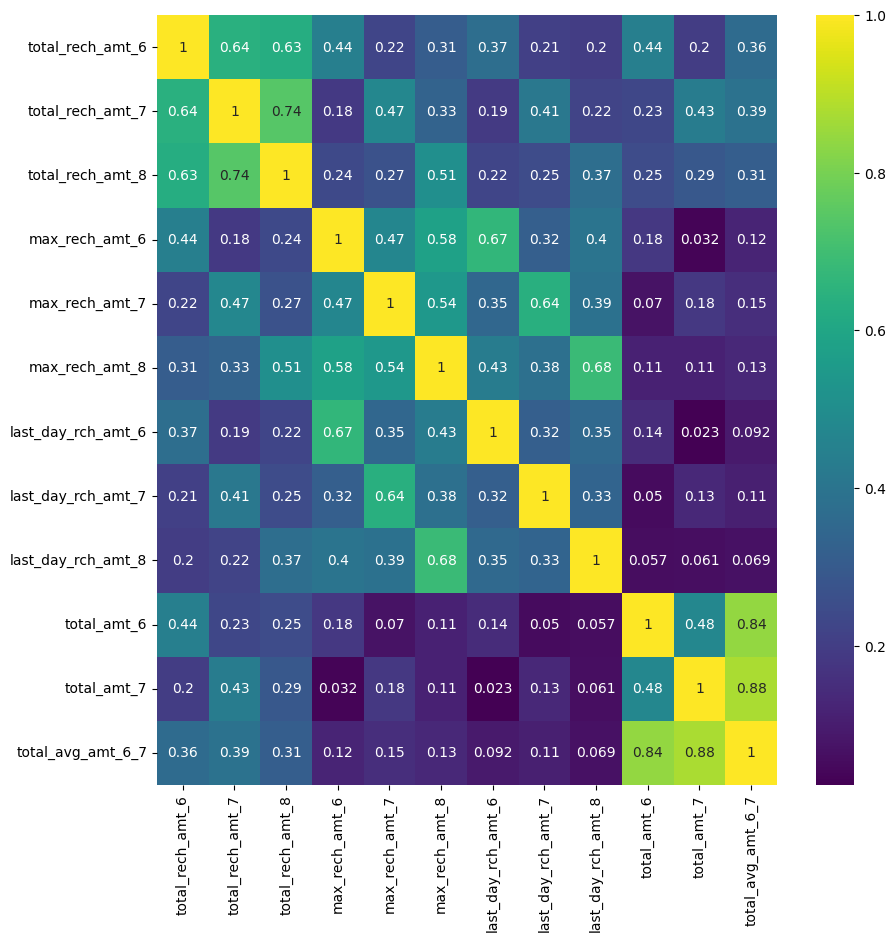

In [79]:
# Amount data
plt.figure(figsize=(10,10))
sns.heatmap(amount_data.corr(), annot=True, cmap='viridis')
plt.show()

***Observations:***
- A substantial correlation of 74% exists between the total recharge amount in month 7 and month 8.
- Similarly, a notable correlation of 68% is observed between the maximum recharge amount in month 8 and the last day's recharge amount in the same month.
- This suggests that customers who are unlikely to churn tend to recharge higher amounts in month 8.

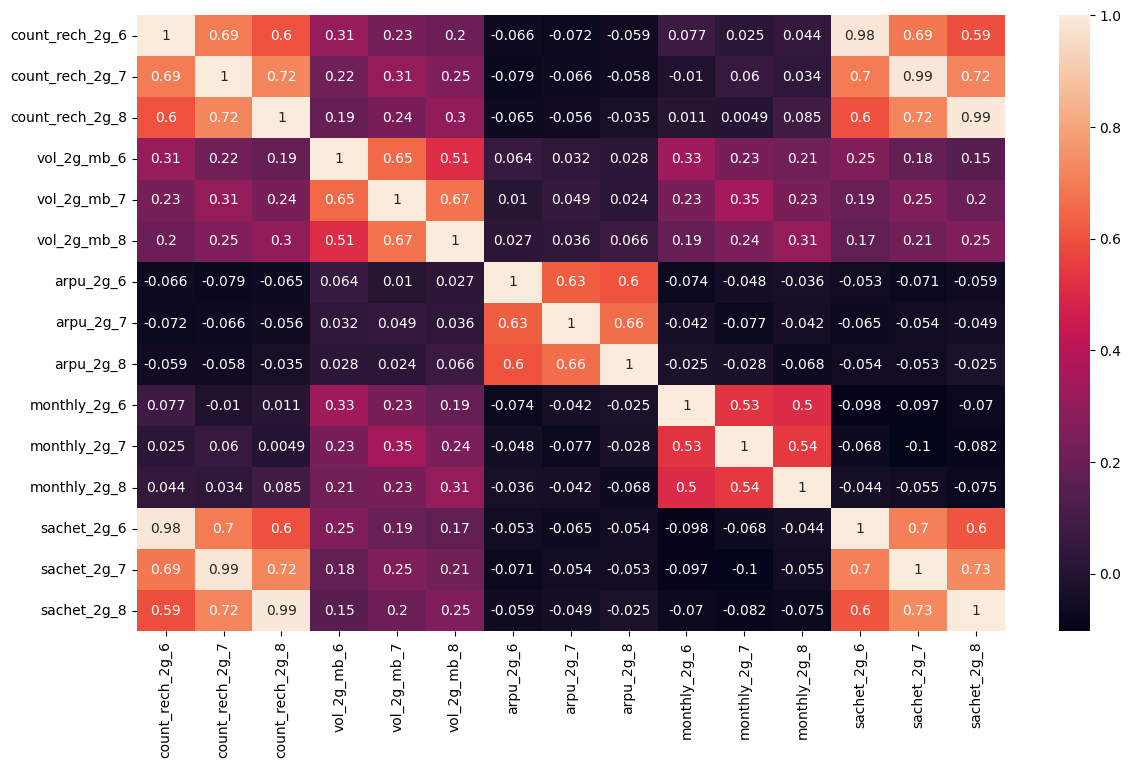

In [80]:
# data2g
plt.figure(figsize=(14,8))
sns.heatmap(data2g.corr(), annot=True)
plt.show()

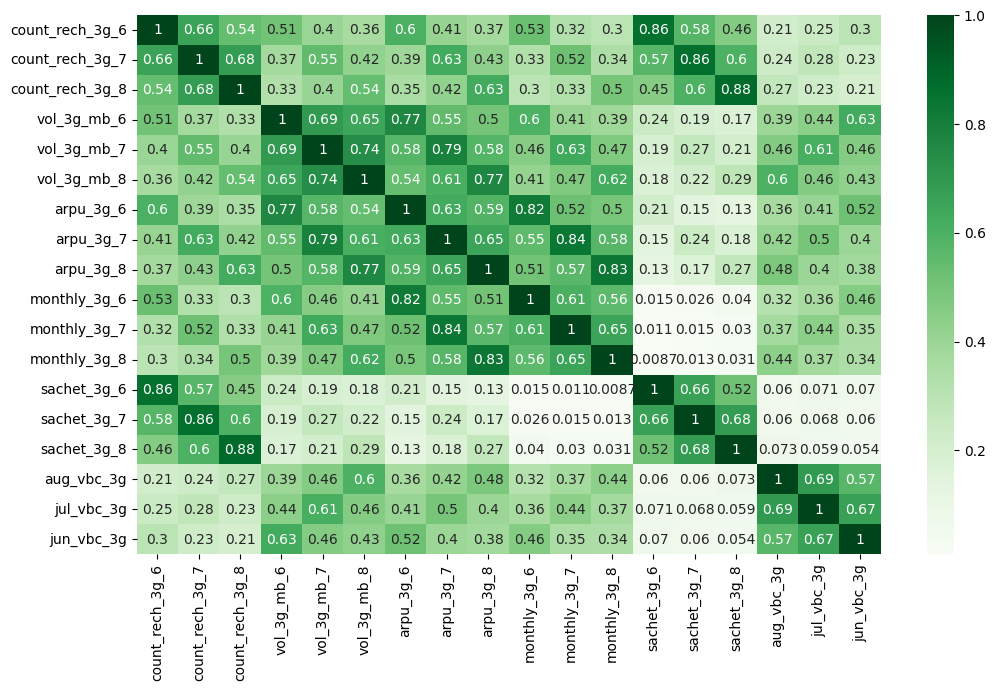

In [81]:
#data3g heatmap.
plt.figure(figsize=(12,7))
sns.heatmap(data3g.corr(),annot=True, cmap='Greens')
plt.show()

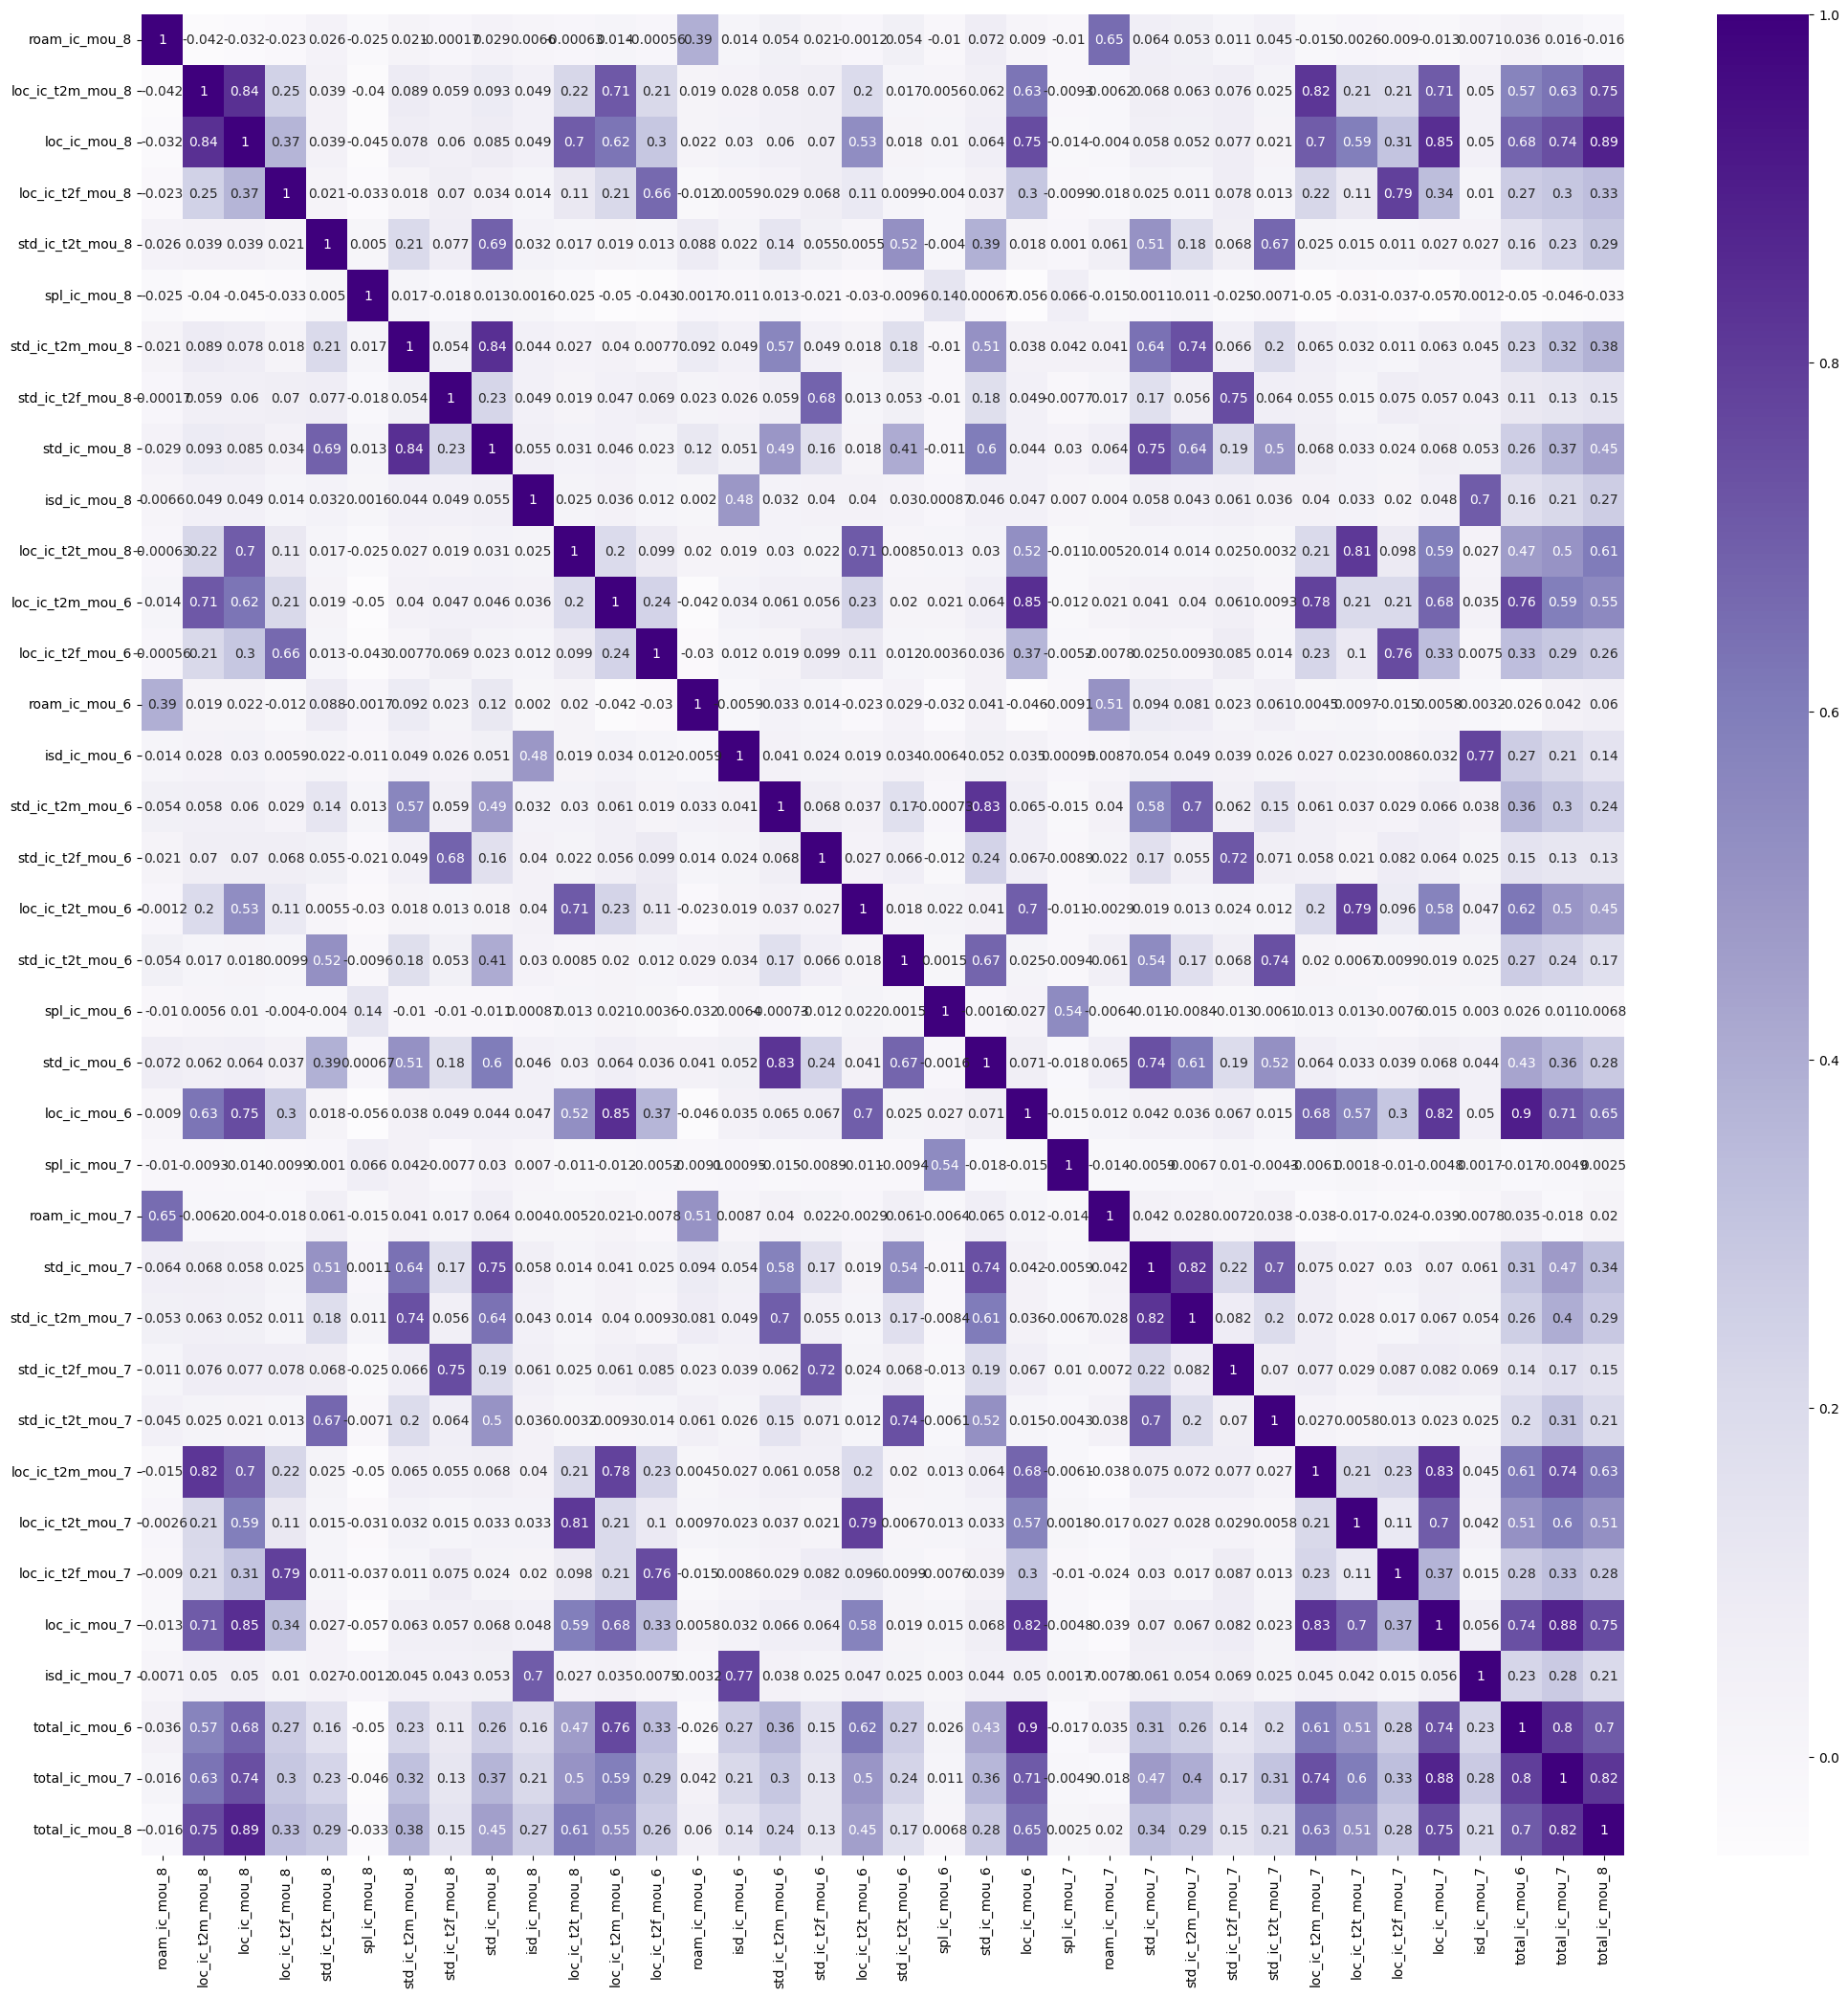

In [82]:
#ic_mou_data
plt.figure(figsize=(25, 25))
sns.heatmap(ic_mou_data.corr(), annot=True, cmap='Purples')
plt.show()

In [83]:
# Calculate correlation matrix for the DataFrame
corr_matrix = ic_mou_data.corr()

# Unstack the correlation matrix
corr_unstacked = corr_matrix.unstack()

# Filter pairs with high correlation (greater than 0.8 or less than -0.8) and remove self-correlations (1.0)
high_corr = corr_unstacked[(abs(corr_unstacked) > 0.8) & (abs(corr_unstacked) < 1.0)]

# Sort by correlation value
high_corr_sorted = high_corr.sort_values(ascending=False)

# Display the sorted high correlations
print(high_corr_sorted)

total_ic_mou_6    loc_ic_mou_6        0.898632
loc_ic_mou_6      total_ic_mou_6      0.898632
loc_ic_mou_8      total_ic_mou_8      0.887782
total_ic_mou_8    loc_ic_mou_8        0.887782
total_ic_mou_7    loc_ic_mou_7        0.877077
loc_ic_mou_7      total_ic_mou_7      0.877077
                  loc_ic_mou_8        0.847219
loc_ic_mou_8      loc_ic_mou_7        0.847219
loc_ic_t2m_mou_6  loc_ic_mou_6        0.845950
loc_ic_mou_6      loc_ic_t2m_mou_6    0.845950
std_ic_mou_8      std_ic_t2m_mou_8    0.839149
std_ic_t2m_mou_8  std_ic_mou_8        0.839149
loc_ic_mou_8      loc_ic_t2m_mou_8    0.836018
loc_ic_t2m_mou_8  loc_ic_mou_8        0.836018
loc_ic_t2m_mou_7  loc_ic_mou_7        0.829759
loc_ic_mou_7      loc_ic_t2m_mou_7    0.829759
std_ic_t2m_mou_6  std_ic_mou_6        0.825267
std_ic_mou_6      std_ic_t2m_mou_6    0.825267
std_ic_mou_7      std_ic_t2m_mou_7    0.824182
std_ic_t2m_mou_7  std_ic_mou_7        0.824182
total_ic_mou_8    total_ic_mou_7      0.822098
total_ic_mou_

***Observations:*** <br/><br/>
The following variables or features has high correlations:

1. total_ic_mou_6 and loc_ic_mou_6
2. total_ic_mou_7 and loc_ic_mou_7
3. total_ic_mou_8 and loc_ic_mou_8
4. std_ic_mou_6 and std_ic_t2f_mou_6
5. std_ic_mou_7 and std_ic_t2f_mou_7
6. std_ic_mou_8 and std_ic_t2f_mou_8

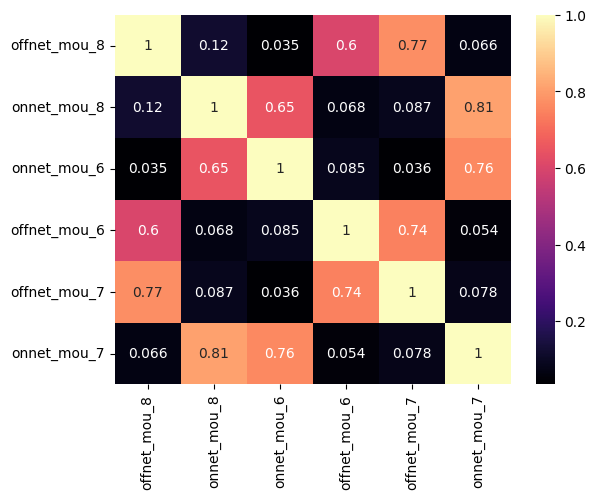

In [84]:
#net_mou_data
sns.heatmap(net_mou_data.corr(), annot=True, cmap='magma')
plt.show()

***Observations:***
- High correlation is observed between the on-net and off-net usage minutes in both months 7 and 8.

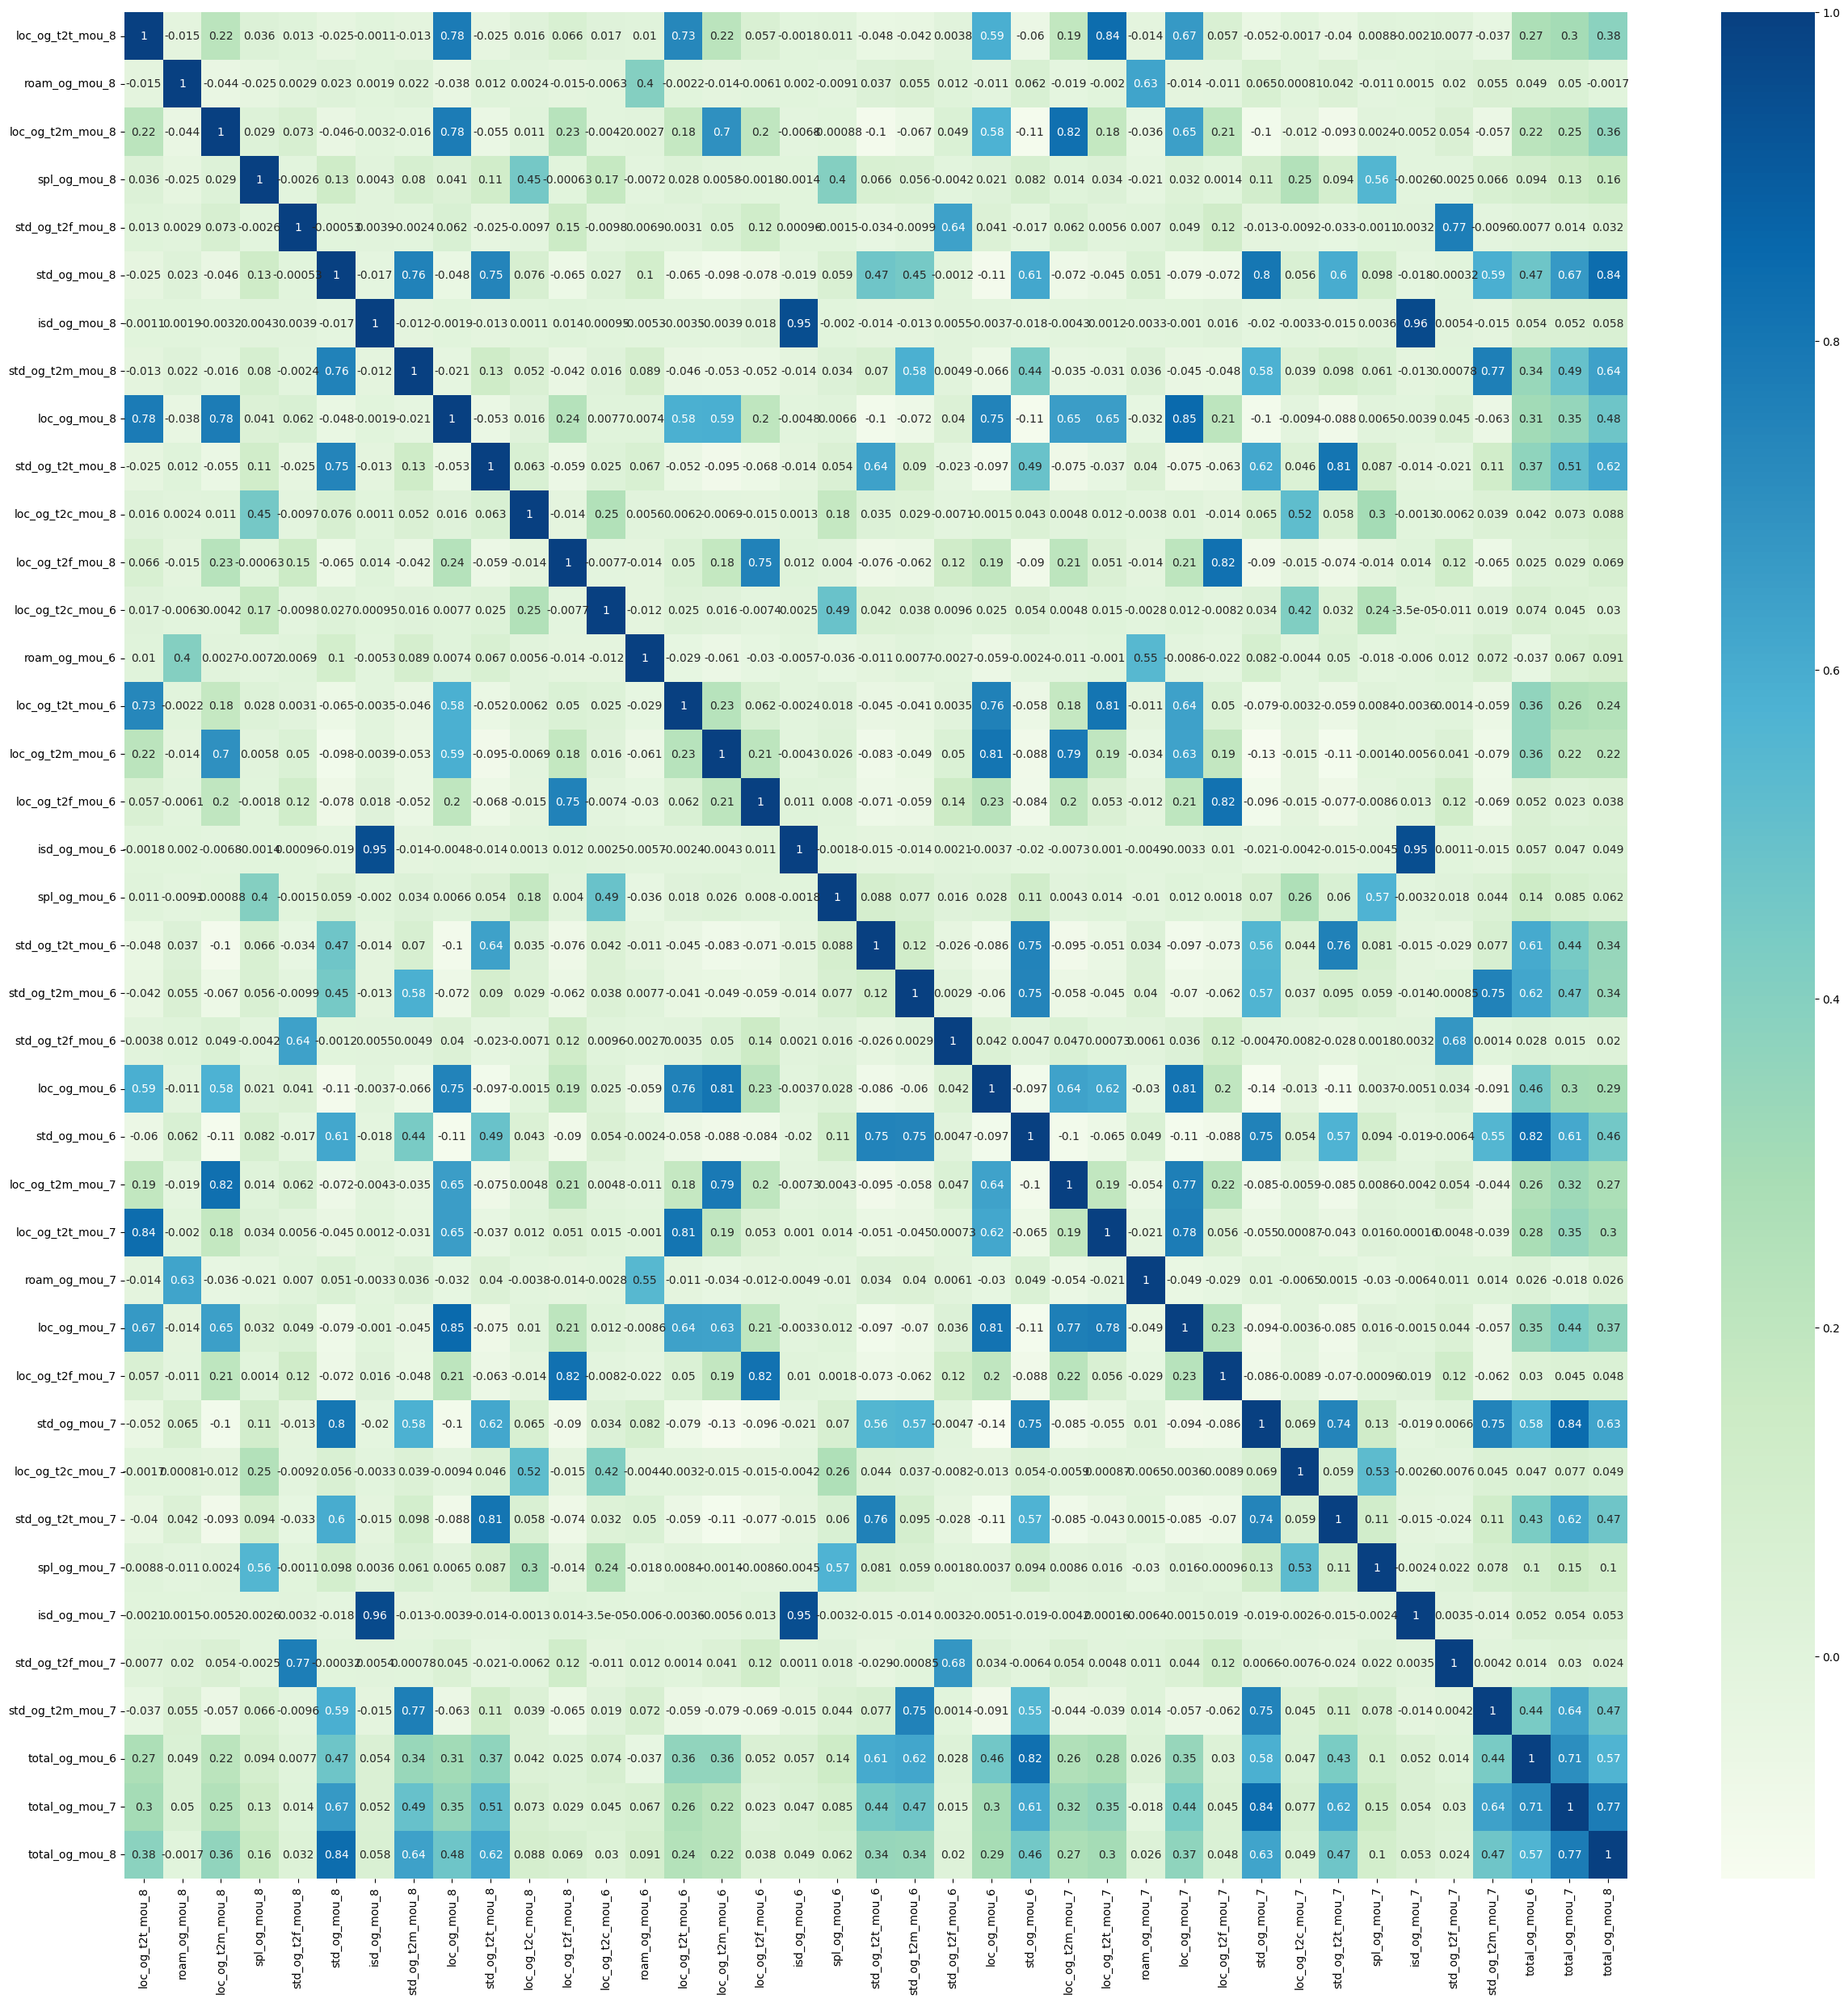

In [85]:
#og_mou_data
plt.figure(figsize=(30,30))
sns.heatmap(og_mou_data.corr(), annot=True, cmap='GnBu')
plt.show()

In [86]:
# Calculate correlation matrix for the DataFrame
corr_matrix = og_mou_data.corr()

# Unstack the correlation matrix
corr_unstacked = corr_matrix.unstack()

# Filter pairs with high correlation (greater than 0.8 or less than -0.8) and remove self-correlations (1.0)
high_corr = corr_unstacked[(abs(corr_unstacked) > 0.8) & (abs(corr_unstacked) < 1.0)]

# Sort by correlation value
high_corr_sorted = high_corr.sort_values(ascending=False)

# Display the sorted high correlations
print(high_corr_sorted)

isd_og_mou_8      isd_og_mou_7        0.960590
isd_og_mou_7      isd_og_mou_8        0.960590
isd_og_mou_6      isd_og_mou_8        0.950687
isd_og_mou_8      isd_og_mou_6        0.950687
isd_og_mou_7      isd_og_mou_6        0.947540
isd_og_mou_6      isd_og_mou_7        0.947540
loc_og_mou_8      loc_og_mou_7        0.845928
loc_og_mou_7      loc_og_mou_8        0.845928
total_og_mou_7    std_og_mou_7        0.841977
std_og_mou_7      total_og_mou_7      0.841977
total_og_mou_8    std_og_mou_8        0.836555
std_og_mou_8      total_og_mou_8      0.836555
loc_og_t2t_mou_8  loc_og_t2t_mou_7    0.836231
loc_og_t2t_mou_7  loc_og_t2t_mou_8    0.836231
loc_og_t2m_mou_8  loc_og_t2m_mou_7    0.824722
loc_og_t2m_mou_7  loc_og_t2m_mou_8    0.824722
std_og_mou_6      total_og_mou_6      0.822717
total_og_mou_6    std_og_mou_6        0.822717
loc_og_t2f_mou_7  loc_og_t2f_mou_8    0.820045
loc_og_t2f_mou_8  loc_og_t2f_mou_7    0.820045
loc_og_t2f_mou_6  loc_og_t2f_mou_7    0.816488
loc_og_t2f_mo

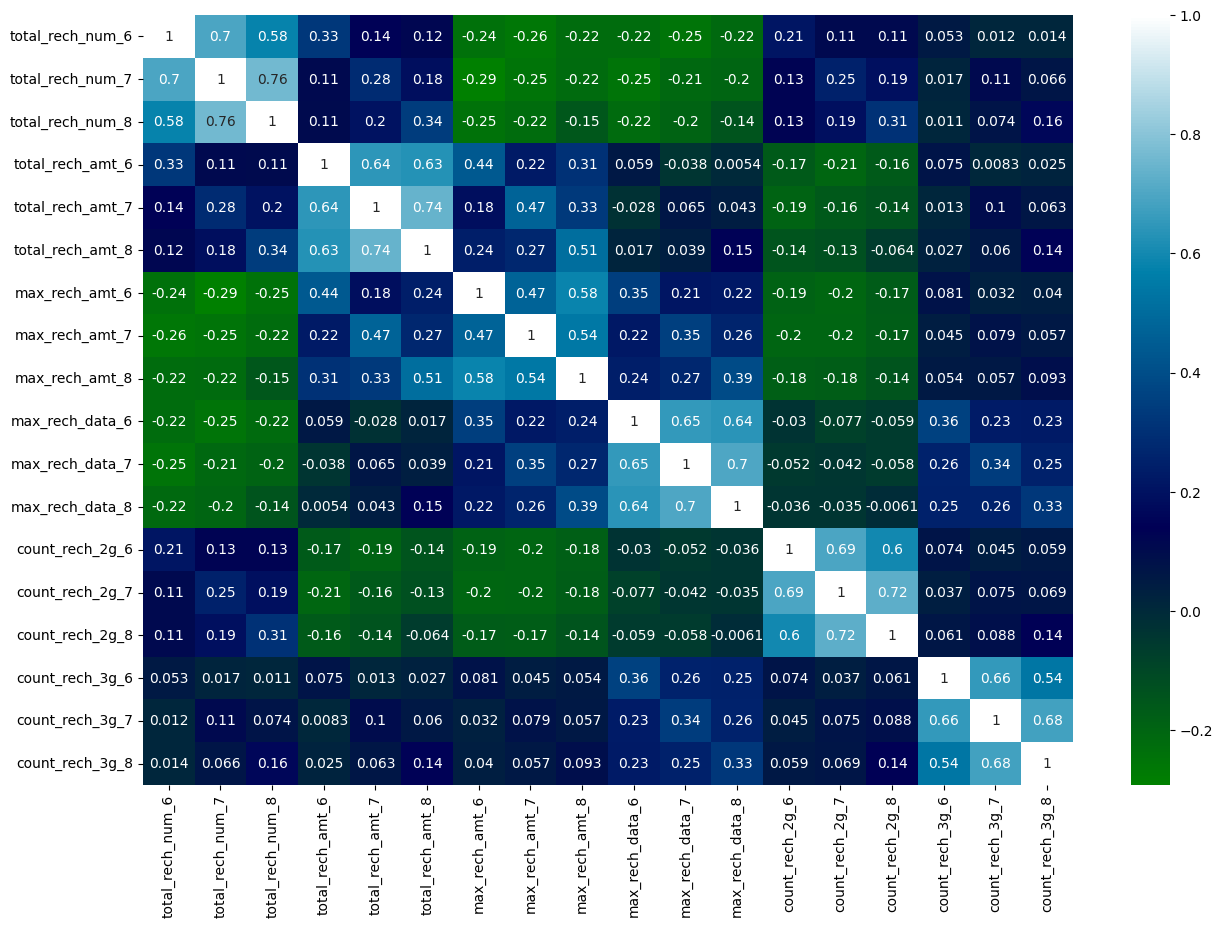

In [87]:
#rech_data
plt.figure(figsize=(15,10))
sns.heatmap(rech_data.corr(), annot=True, cmap='ocean')
plt.show()

In [88]:
# Calculate correlation matrix for the DataFrame
corr_matrix = rech_data.corr()

# Unstack the correlation matrix
corr_unstacked = corr_matrix.unstack()

# Filter pairs with high correlation (greater than 0.7 or less than -0.8) and remove self-correlations (1.0)
high_corr = corr_unstacked[(abs(corr_unstacked) > 0.7) & (abs(corr_unstacked) < 1.0)]

# Sort by correlation value
high_corr_sorted = high_corr.sort_values(ascending=False)

# Display the sorted high correlations
print(high_corr_sorted)

total_rech_num_7  total_rech_num_8    0.760753
total_rech_num_8  total_rech_num_7    0.760753
total_rech_amt_7  total_rech_amt_8    0.740675
total_rech_amt_8  total_rech_amt_7    0.740675
count_rech_2g_7   count_rech_2g_8     0.723976
count_rech_2g_8   count_rech_2g_7     0.723976
dtype: float64


In [89]:
final_df.shape

(20998, 149)

In [90]:
final_unseen_df.shape

(30000, 149)

Dummy Variables for Categorical Columns ( Onehot encoding)

In [91]:
final_df[categorical_columns]

night_pck_user_6 night_pck_user_7 night_pck_user_8 fb_user_6 fb_user_7  \
0                  0.0              0.0              0.0       1.0       1.0   
1                  0.0             -1.0              0.0       1.0      -1.0   
2                 -1.0             -1.0             -1.0      -1.0      -1.0   
3                  0.0              0.0              0.0       0.0       0.0   
4                  0.0              0.0              0.0       1.0       1.0   
...                ...              ...              ...       ...       ...   
20993              0.0             -1.0             -1.0       1.0      -1.0   
20994              1.0              0.0              0.0       1.0       1.0   
20995              0.0              0.0             -1.0       1.0       1.0   
20996             -1.0              0.0              0.0      -1.0       1.0   
20997              0.0              0.0              0.0       1.0       1.0   

      fb_user_8  
0           1.0  
1           1.0  
2          -1.0  
3           0.0  
4           1.0  
...         ...  
20993      -1.0  
20994       1.0  
20995      -1.0  
20996       1.0  
20997       1.0  

[20998 rows x 6 columns]

In [92]:
# Creating dummies for categorical columns
dummy_df = pd.get_dummies(final_df[categorical_columns], drop_first=True, dtype='int')

In [93]:
final_df = pd.concat([final_df, dummy_df], axis=1)

In [94]:
# drop the category cols
final_df.drop(categorical_columns, axis=1, inplace=True)

In [95]:
final_df.shape

(20998, 155)

In [96]:
# Creating dummies for categorical columns
dummy_unseen_df = pd.get_dummies(final_unseen_df[categorical_columns], drop_first=True, dtype='int')

In [97]:
final_unseen_df = pd.concat([final_unseen_df, dummy_unseen_df], axis=1)

In [98]:
# drop the category cols
final_unseen_df.drop(categorical_columns, axis=1, inplace=True)

In [99]:
final_unseen_df.shape

(30000, 155)

In [100]:
def plot_box_chart(attribute):
    plt.figure(figsize=(20, 16))
    df = final_df


    plt.subplot(2, 3, 1)
    sns.boxplot(data=df, y=attribute+"_6", x="churn_probability", hue="churn_probability", showfliers=False, palette="tab10")

    plt.subplot(2, 3, 2)
    sns.boxplot(data=df, y=attribute+"_7", x="churn_probability", hue="churn_probability", showfliers=False, palette="tab10")

    plt.show()

In [101]:
def plot_distributions(dataframe, columns, cols_per_row=3):
    num_columns = len(columns)
    num_rows = (num_columns + cols_per_row - 1) // cols_per_row  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i, col in enumerate(columns):
        sns.distplot(dataframe[col], ax=axes[i], label=col)
        axes[i].legend()

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

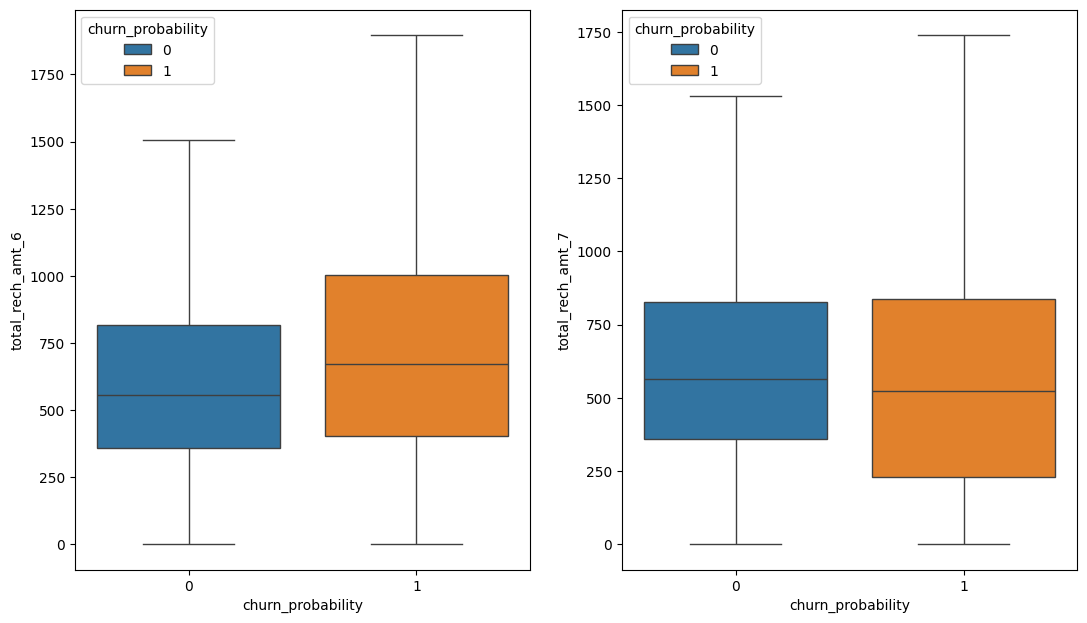

In [102]:
plot_box_chart('total_rech_amt')

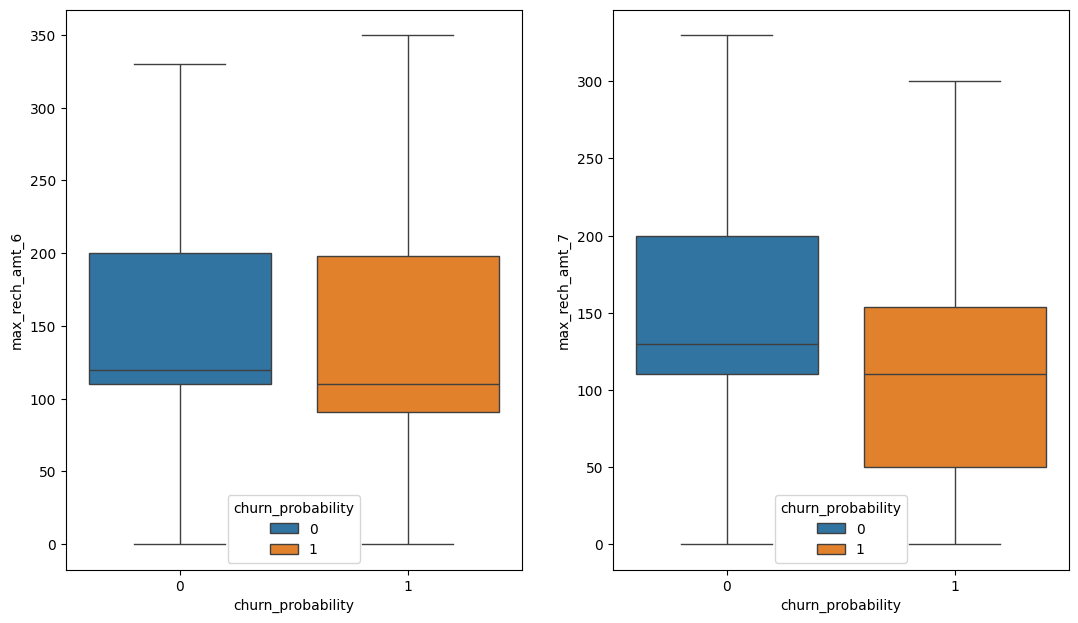

In [103]:
plot_box_chart('max_rech_amt')

In [104]:
numerical_cols = list(final_df.select_dtypes(exclude='category'))

#plot_distributions(final_df, numerical_cols)

In [105]:
# Outlier handling function
def outlier_handling(series):
    transformed_values = []
    for value in series:
        if value <= 0:
            transformed_values.append(0)  # Adjust this if needed based on analysis
        elif value == 1.0:
            transformed_values.append(1.5)  # Ensure this transformation is justified
        else:
            transformed_values.append(np.log1p(value))  # Log transform for skewed distributions
    return transformed_values

In [106]:
def plot_boxplots(dataframe, column_pattern, num_columns=3):
    # Filter columns that contain the specified pattern
    columns = dataframe.columns[dataframe.columns.str.contains(column_pattern)]

    # Determine the number of rows needed
    num_rows = (len(columns) + num_columns - 1) // num_columns

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Plot each boxplot
    for idx, col in enumerate(columns):
        sns.boxplot(dataframe[col], ax=axes[idx])
        axes[idx].set_title('Boxplot of ' + col)
        axes[idx].set_xlabel(col)

    # Remove any unused subplots
    for idx in range(len(columns), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

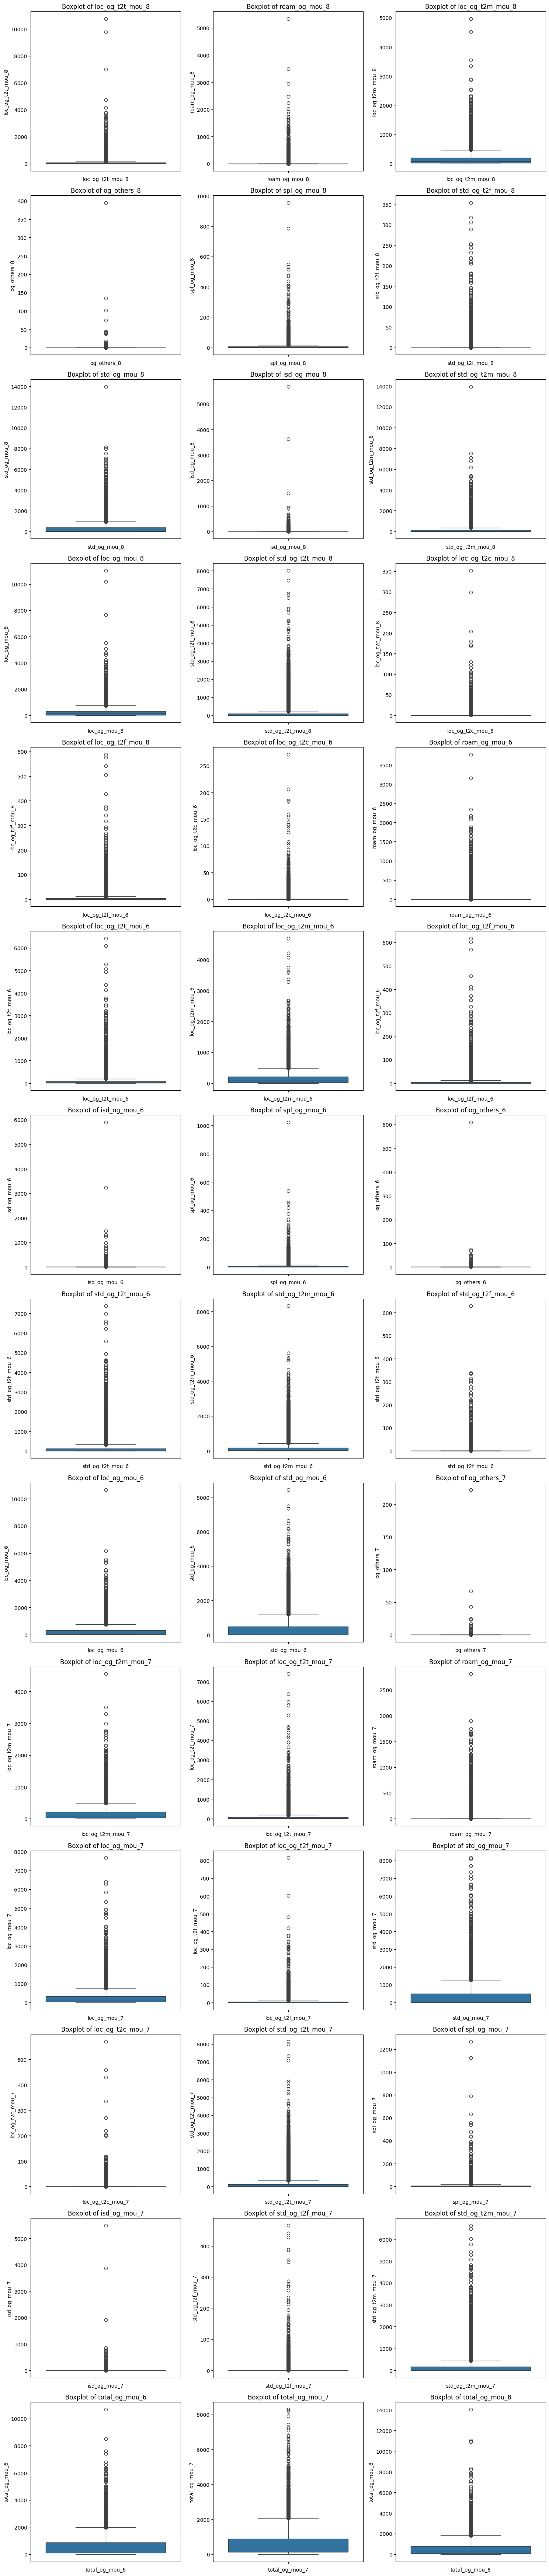

In [107]:
# Call the function for Outgoing variables.
plot_boxplots(final_df, "og")

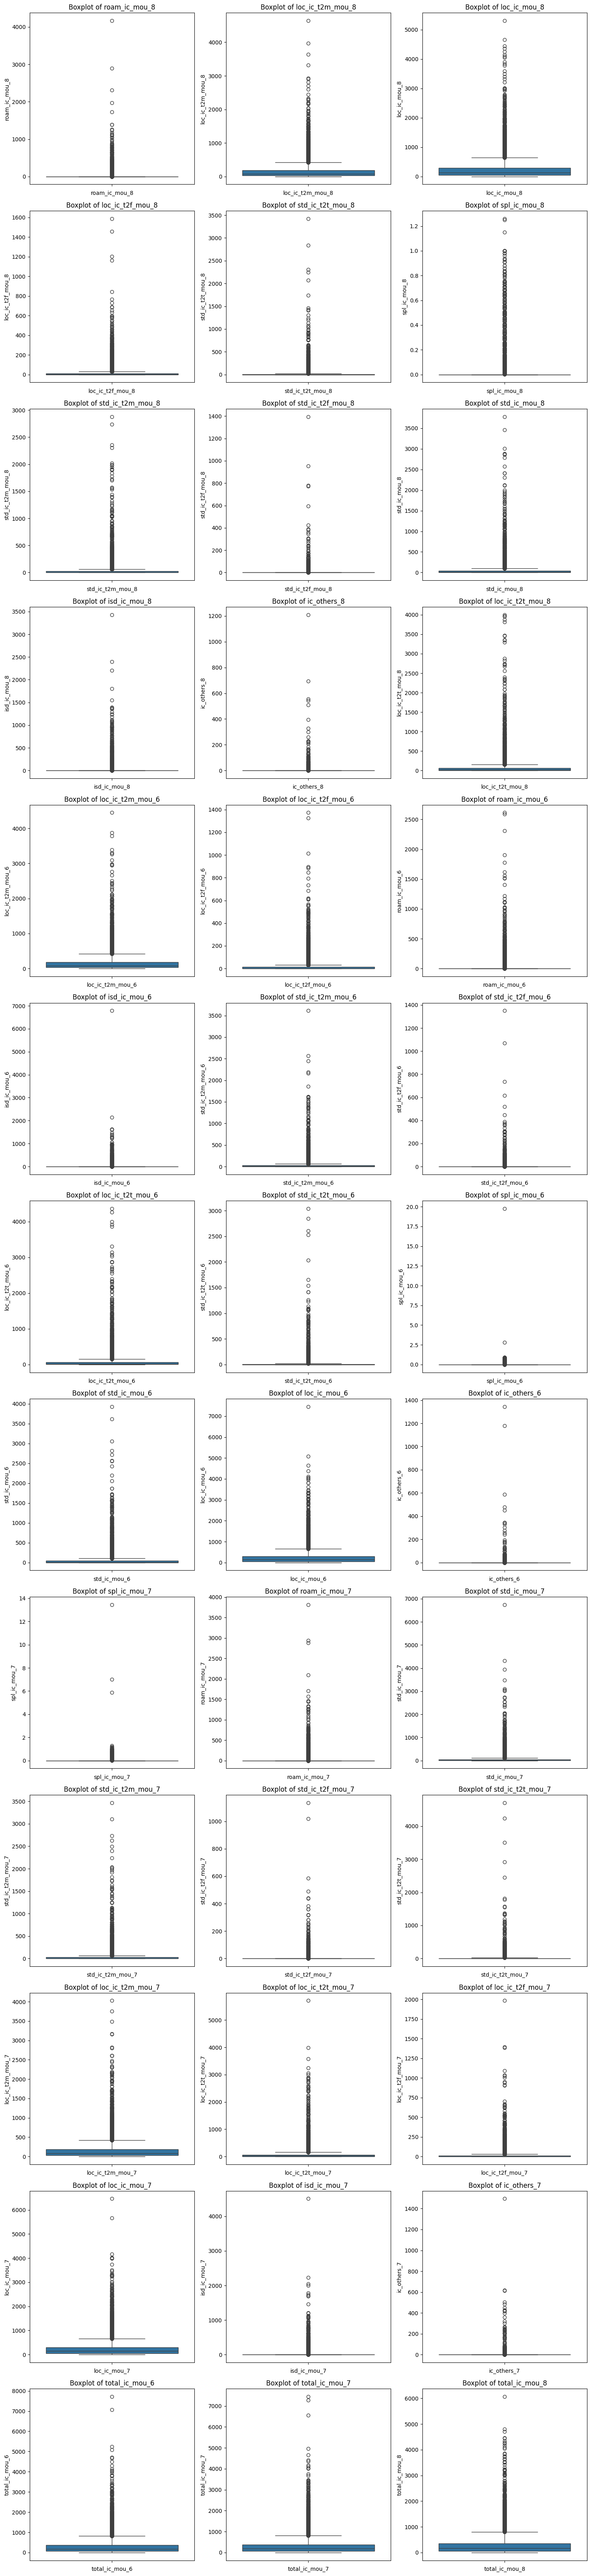

In [108]:
#Call the function for Incoming variables.
plot_boxplots(final_df, "ic")

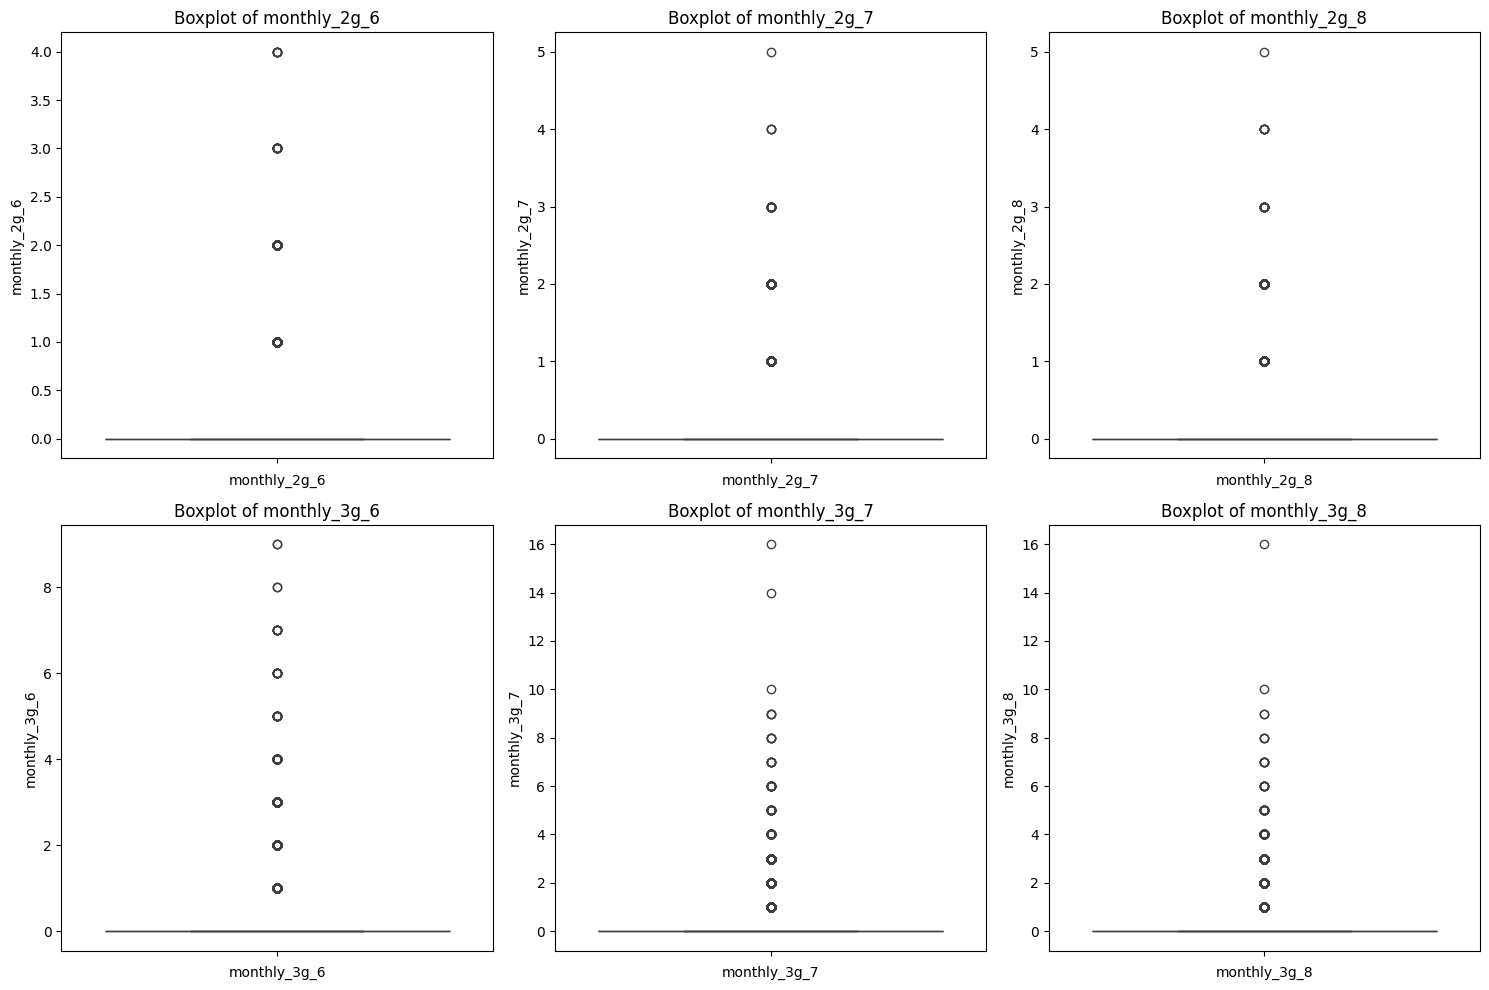

In [109]:
plot_boxplots(final_df, "monthly")

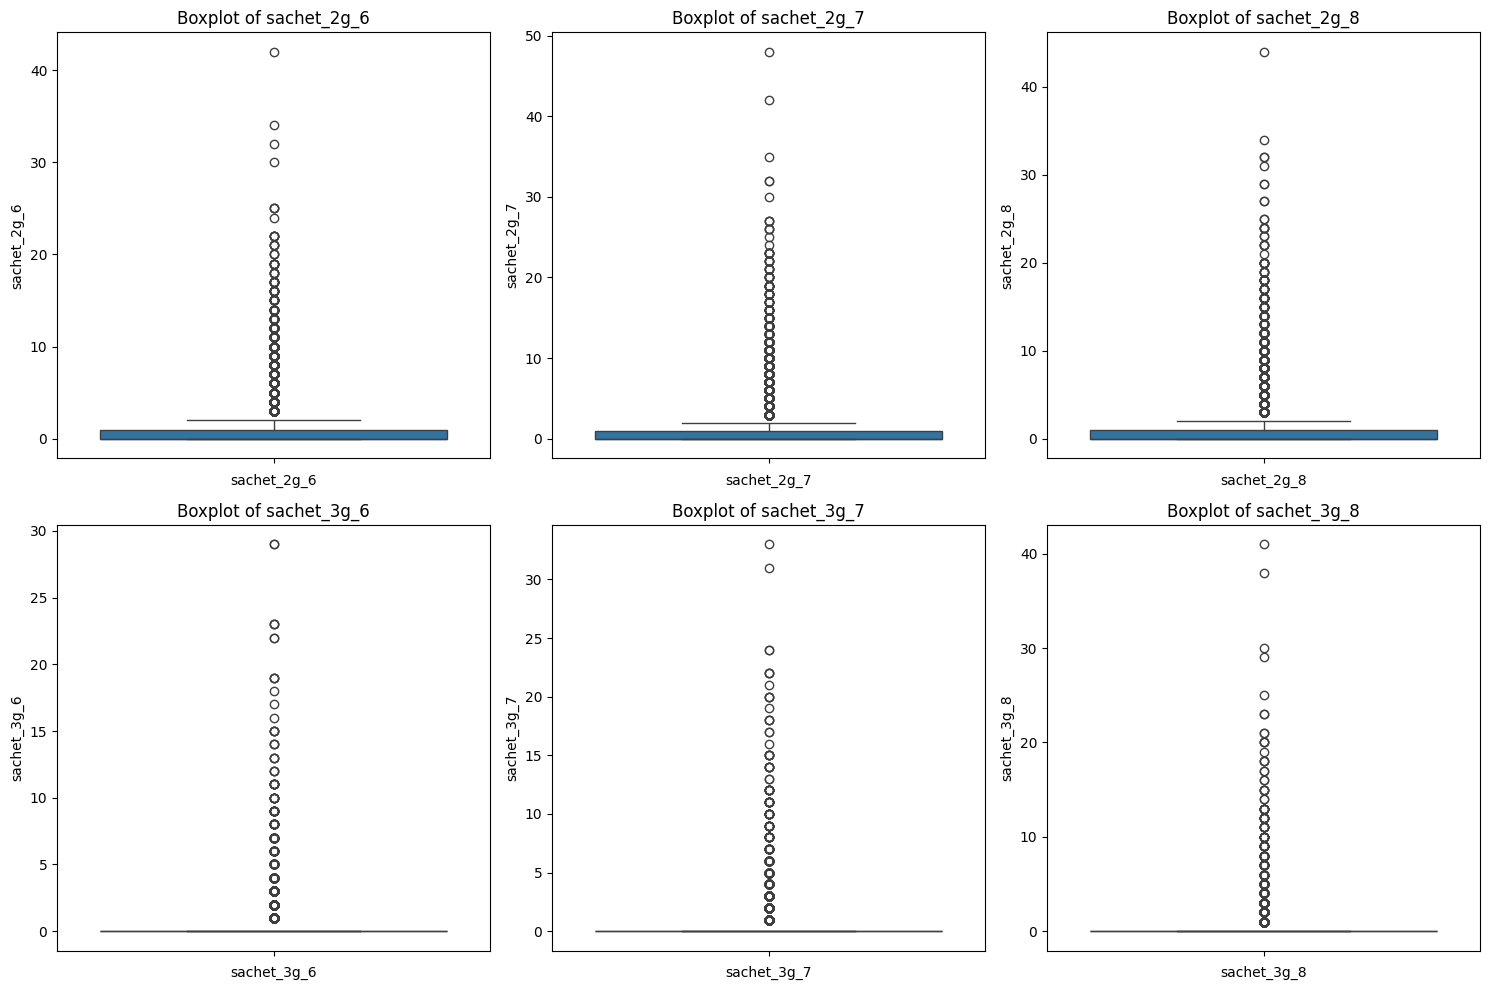

In [110]:
# Service schemes with validity smaller than a month
plot_boxplots(final_df, "sachet")

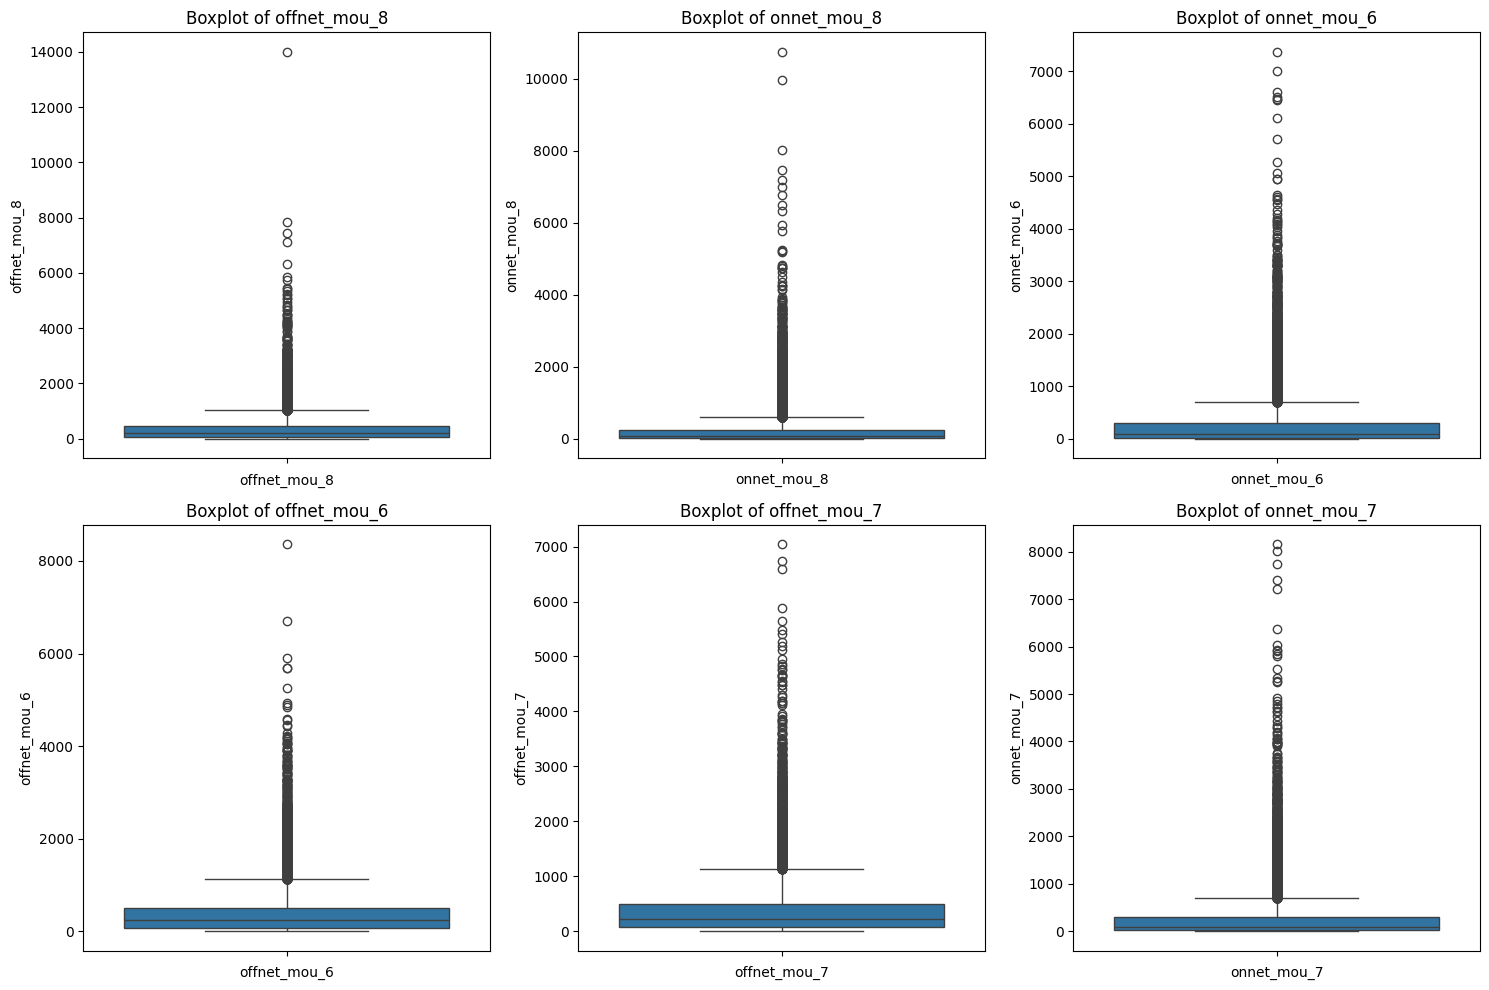

In [111]:
# All kind of calls within the same operator network - ONNET
# All kind of calls outside the operator T network - OFFNET
plot_boxplots(final_df, "net")

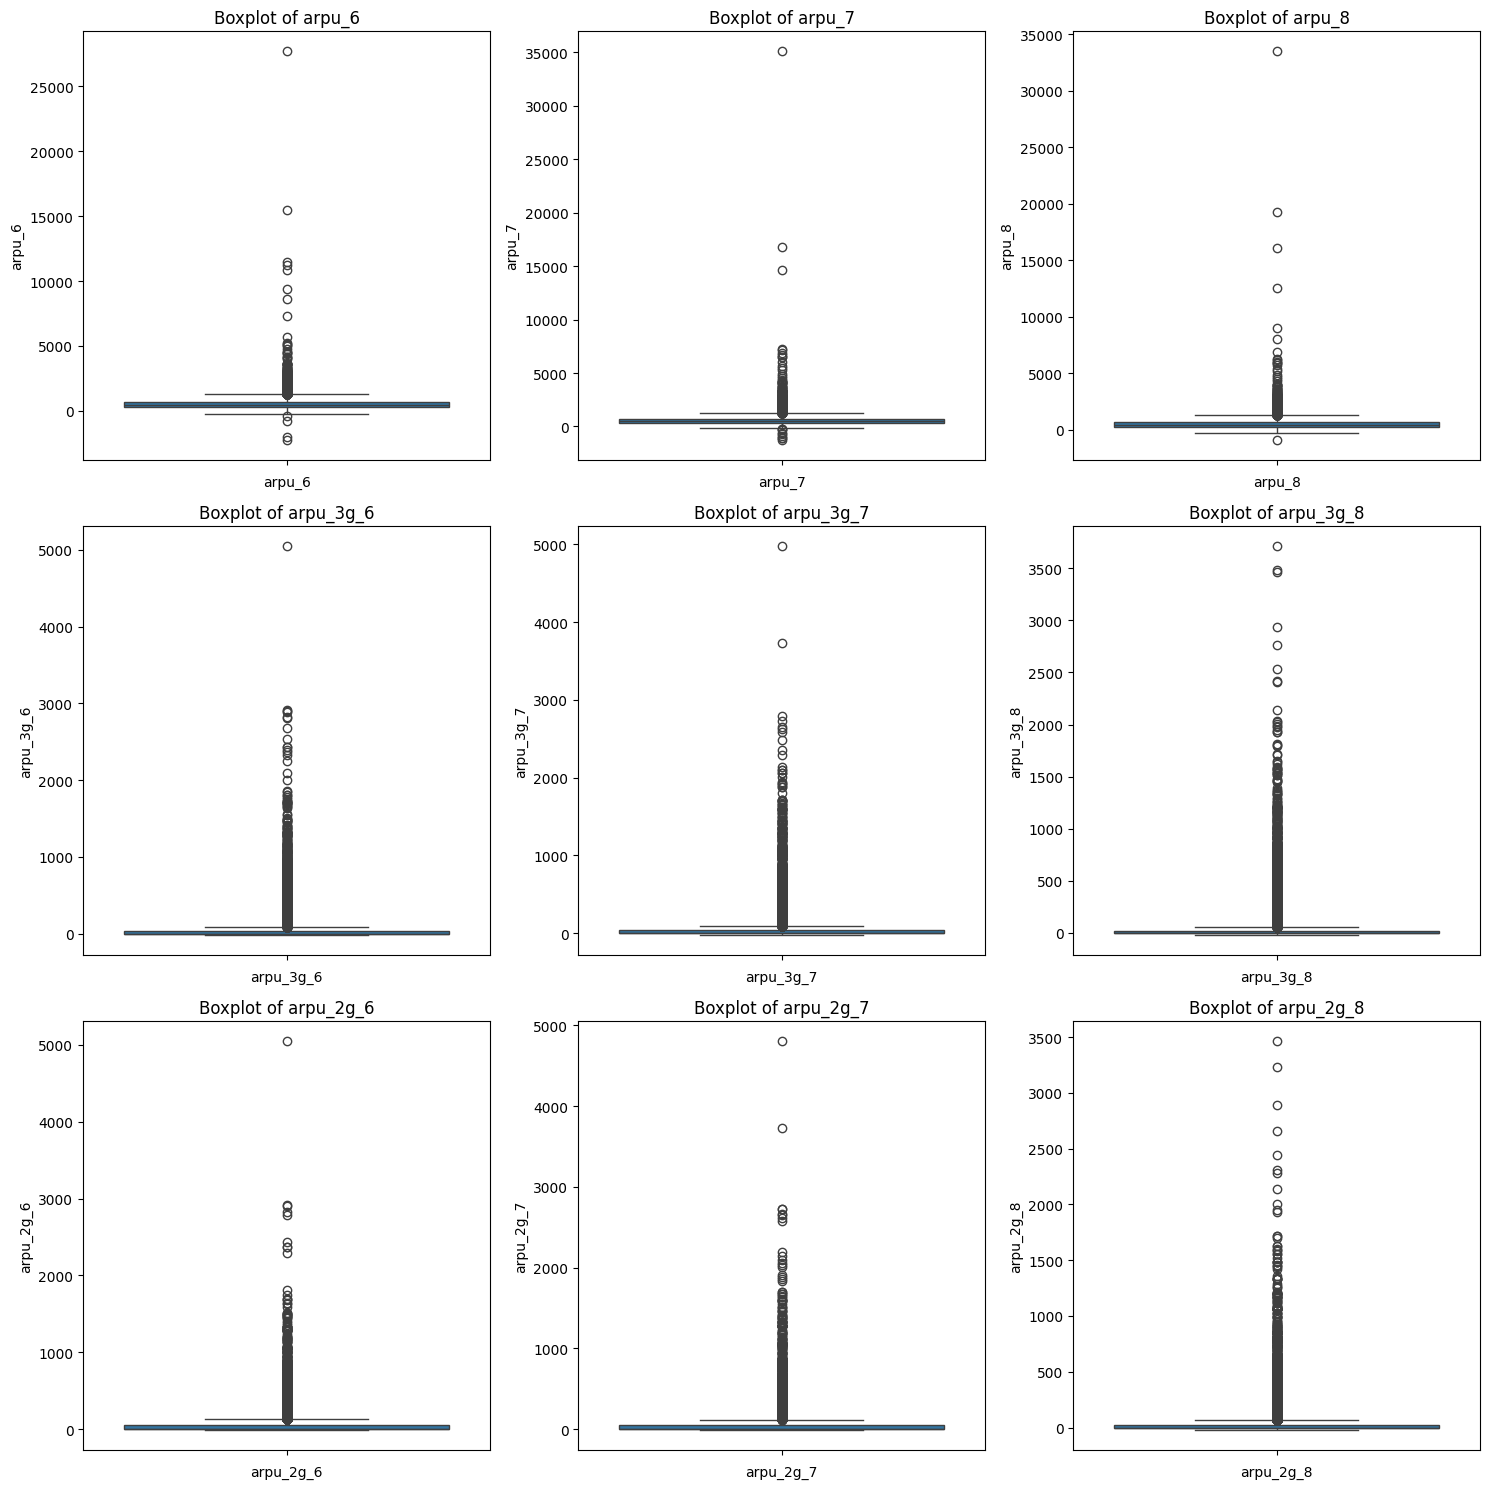

In [112]:
plot_boxplots(final_df, "arpu")

#### For checking Outlier handling is applied. If not required we can remove it.

In [113]:
final_df[numerical_cols] = final_df[numerical_cols].apply(outlier_handling)


In [114]:
# Handle outliers of numerical columns in the test set
final_unseen_df[numerical_cols] = final_unseen_df[numerical_cols].apply(outlier_handling)

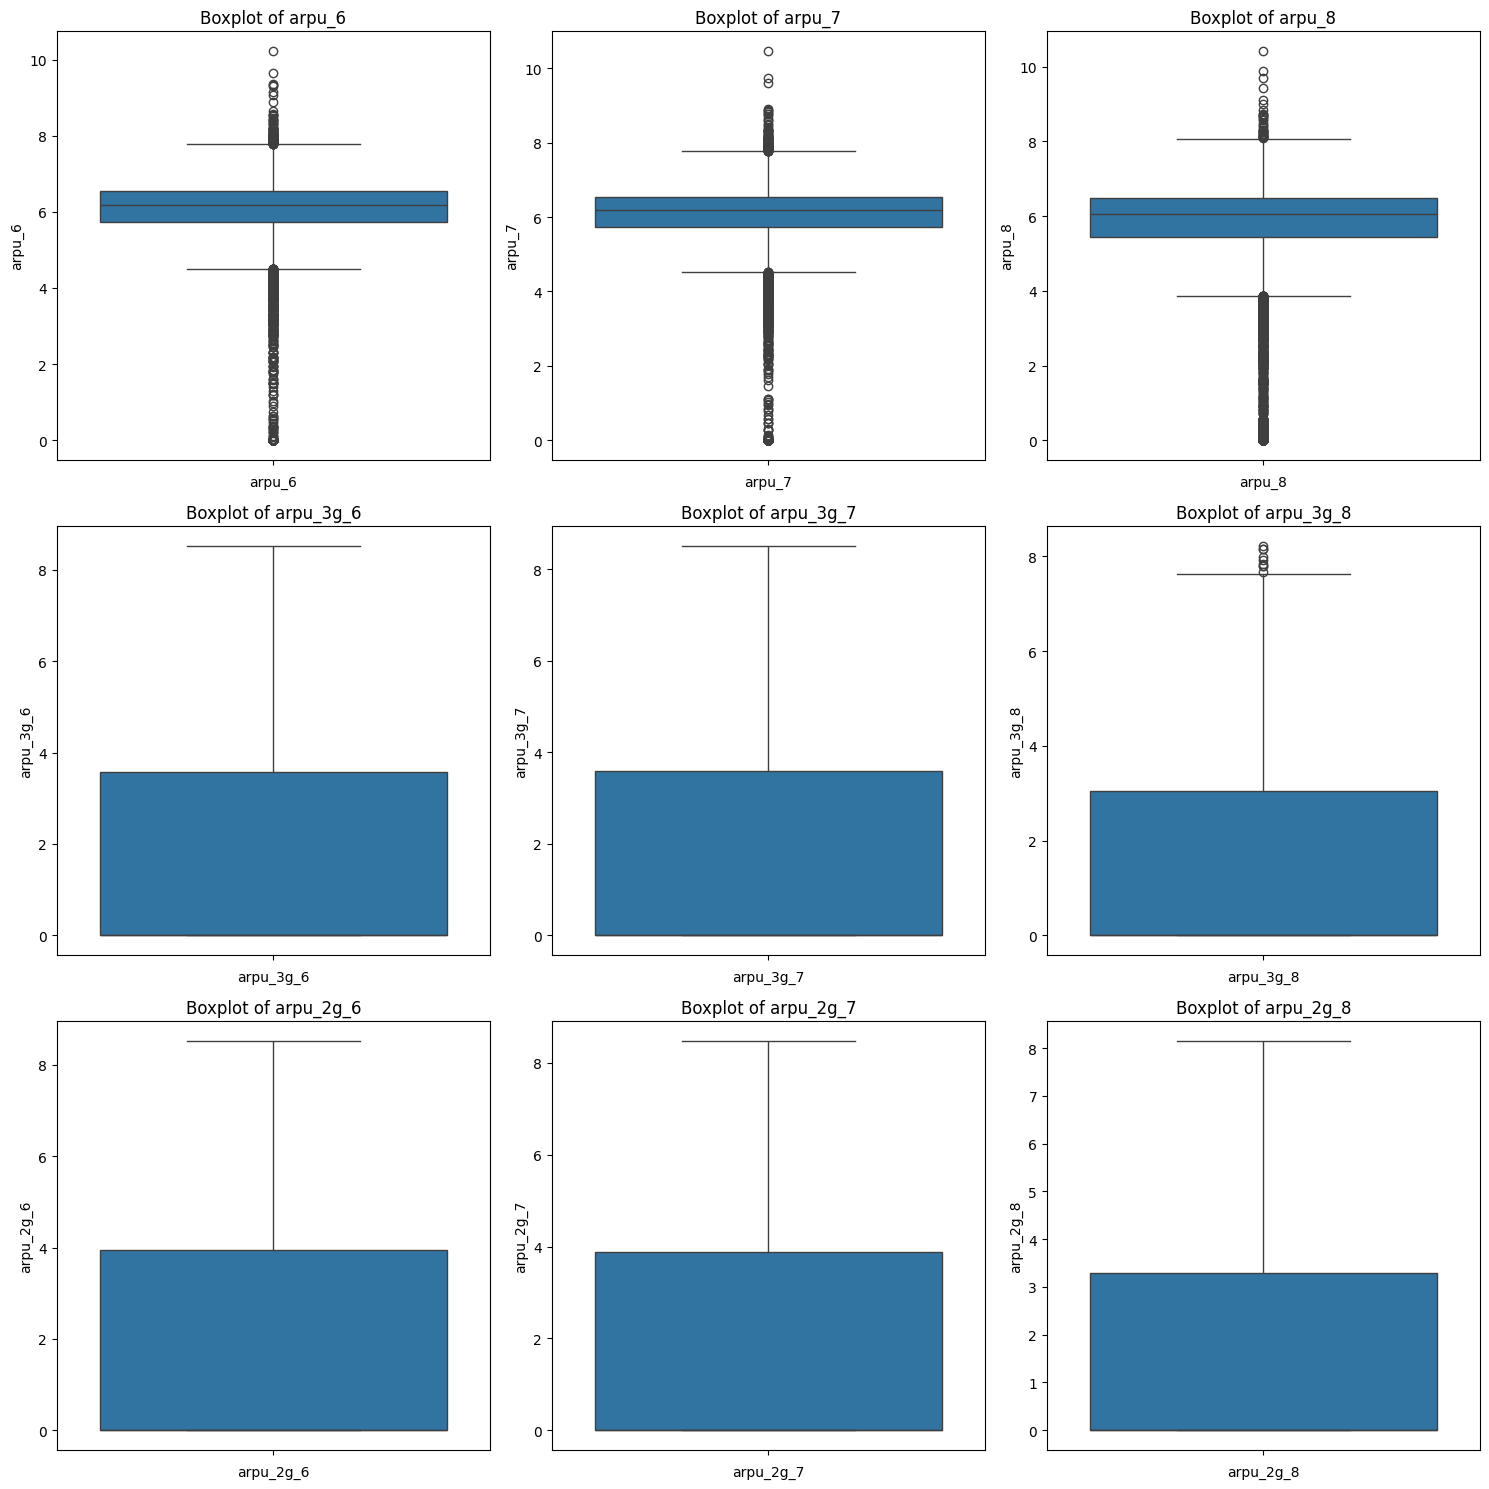

In [115]:
plot_boxplots(final_df, "arpu")

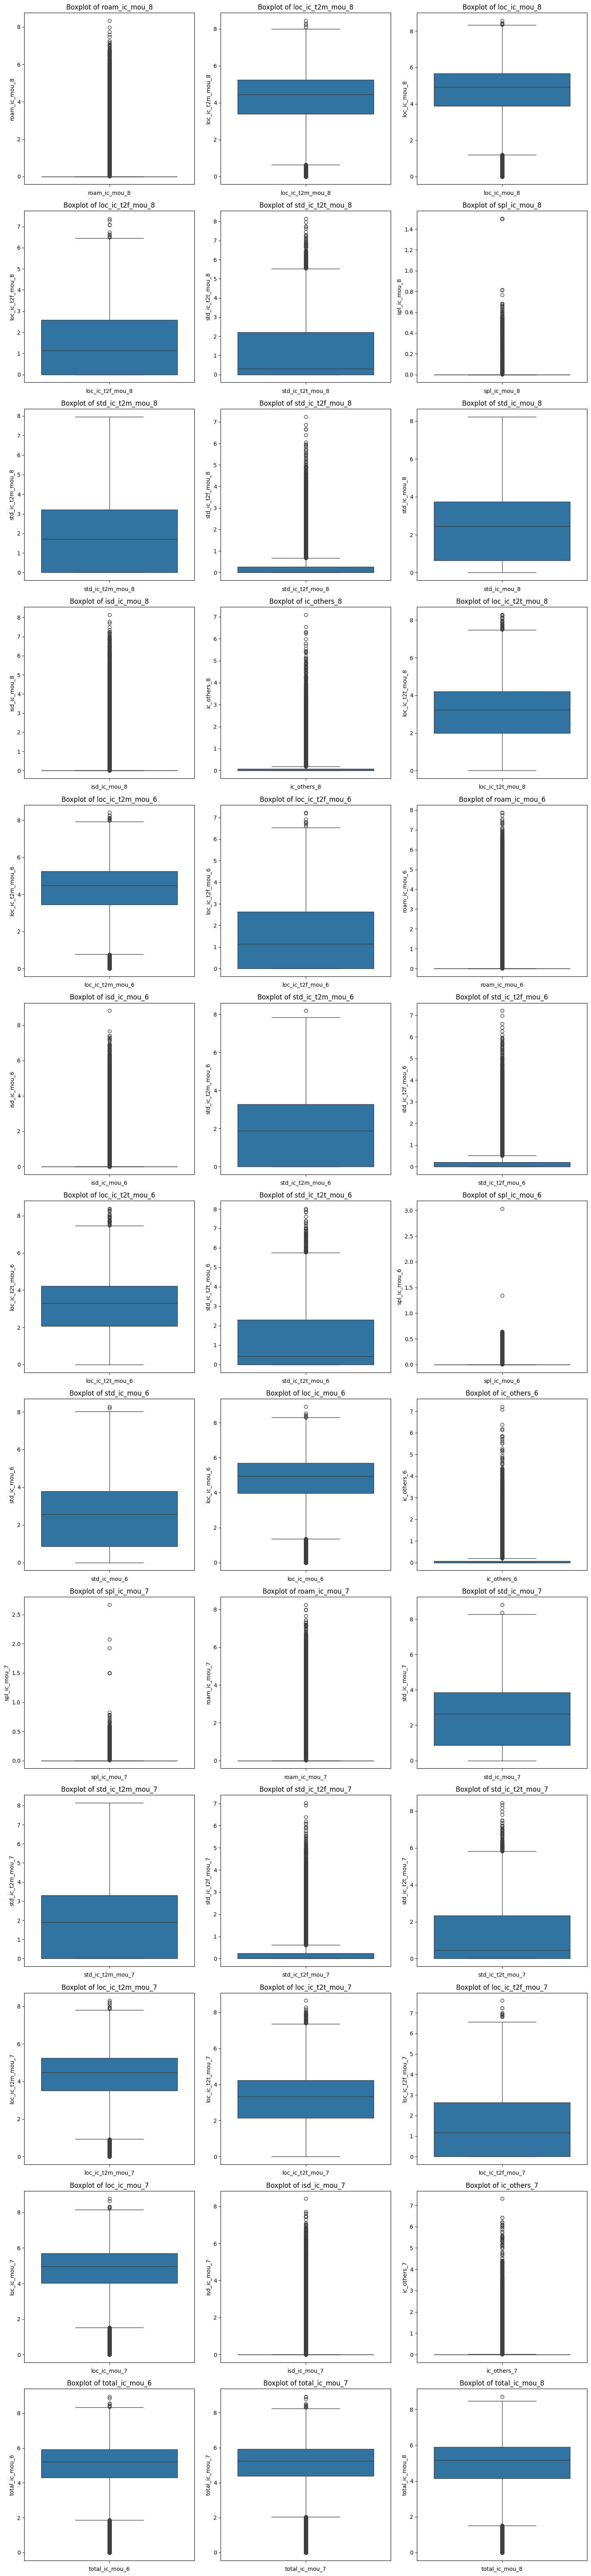

In [116]:
plot_boxplots(final_df, "ic")


# 4. Model Selection and Model Building

### Train Test Split

We will be running and evaluating model on training.csv file. test.csv is for submission.

In [117]:
# Partitioning the dataset into the feature variable 'X' and the response variable 'y'.
X = final_df.drop(['churn_probability'], axis=1)
y = final_df['churn_probability']

In [118]:
print(X.shape)
print(y.shape)

(20998, 154)
(20998,)


In [119]:
print(final_unseen_df.shape)

(30000, 155)


In [120]:
# Split data into train & test data - We have decided to use 80% data for the training.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100, stratify=y)

In [121]:
# Checking the shape after split
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('X_test Shape:', X_test.shape)
print('y_test Shape:', y_test.shape)

X_train Shape: (16798, 154)
y_train Shape: (16798,)
X_test Shape: (4200, 154)
y_test Shape: (4200,)


In [122]:
y_train.value_counts()

churn_probability
0    15410
1     1388
Name: count, dtype: int64

In [123]:
X_train.head()

loc_og_t2t_mou_8  roam_og_mou_8  roam_ic_mou_8  offnet_mou_8  \
1131           1.650580            0.0            0.0      5.704549   
11147          1.899118            0.0            0.0      4.848744   
15767          1.075002            0.0            0.0      3.282038   
13886          3.517795            0.0            0.0      4.201404   
20110          2.907447            0.0            0.0      5.431930   

       onnet_mou_8  loc_og_t2m_mou_8  loc_ic_t2m_mou_8  loc_ic_mou_8  \
1131      1.650580          5.704549          5.363215      5.490960   
11147     1.899118          4.775841          4.337421      4.490657   
15767     1.075002          3.282038          5.402813      5.671122   
13886     4.090337          3.920586          5.060631      5.463535   
20110     5.019793          5.318267          4.923478      5.058536   

       loc_ic_t2f_mou_8  std_ic_t2t_mou_8  ...  night_pck_user_7_0.0  \
1131           2.713369          0.182322  ...                   1.5   
11147          1.947338          0.000000  ...                   1.5   
15767          3.066191          0.000000  ...                   1.5   
13886          0.506818          3.187592  ...                   0.0   
20110          1.410987          0.000000  ...                   1.5   

       night_pck_user_7_1.0  night_pck_user_8_0.0  night_pck_user_8_1.0  \
1131                    0.0                   1.5                   0.0   
11147                   0.0                   0.0                   0.0   
15767                   0.0                   1.5                   0.0   
13886                   0.0                   0.0                   0.0   
20110                   0.0                   0.0                   0.0   

       fb_user_6_0.0  fb_user_6_1.0  fb_user_7_0.0  fb_user_7_1.0  \
1131             0.0            1.5            0.0            1.5   
11147            0.0            1.5            0.0            1.5   
15767            0.0            1.5            0.0            1.5   
13886            0.0            0.0            0.0            0.0   
20110            0.0            0.0            1.5            0.0   

       fb_user_8_0.0  fb_user_8_1.0  
1131             0.0            1.5  
11147            0.0            0.0  
15767            0.0            1.5  
13886            0.0            0.0  
20110            0.0            0.0  

[5 rows x 154 columns]

Handling Class Imbalance using SMOTE


In [124]:
smt = SMOTE(random_state=42)
X_train_smote, y_train_smote = smt.fit_resample(X_train, y_train)

In [125]:
print(X_train_smote.shape)
print(y_train_smote.shape)

(30820, 154)
(30820,)


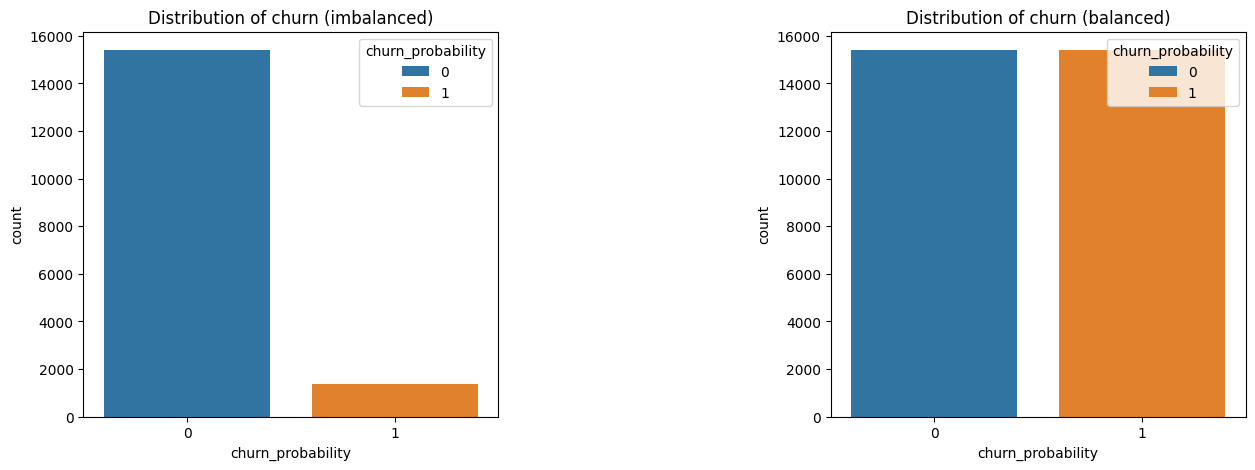

In [126]:
# Checking the distribution on our target variable 'y_train' before and after SMOTE
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.title("Distribution of churn (imbalanced)")
sns.countplot(x=y_train, hue=y_train)

plt.subplot(1,2,2)
plt.title("Distribution of churn (balanced)")
sns.countplot(x=y_train_smote, hue=y_train_smote)

plt.subplots_adjust(wspace=0.8)
plt.show()

### Now, Let's apply Feature Scaling using SandardScaler - Training Set and Test Set

In [127]:
# Use SandardScaler to scale values
scaler = StandardScaler()

# Fit and transform training set
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_smote), columns = X_train_smote.columns, index = X_train_smote.index)

# Only Transform validation set
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns, index = X_test.index)

In [128]:
final_unseen_df.set_index('id', inplace=True)

## Model Building

In [129]:
def evaluate_model(classifier, X_train, y_train, X_test, y_test):
    
    """
    Evaluates the performance of a given classifier by calculating various 
    metrics for both the train and test datasets and displays the results.

    Parameters:
    - classifier: The trained model to evaluate.
    - X_train: Features for the training set.
    - y_train: Labels for the training set.
    - X_test: Features for the test set.
    - y_test: Labels for the test set.
    
    Returns:
    - Prints a DataFrame with the calculated metrics for both train and test sets.
    - Displays confusion matrices for both train and test sets.
    """
    
    # Predictions for Train and Test datasets
    y_train_pred = classifier.predict(X_train)
    y_test_pred = classifier.predict(X_test)
    y_train_proba = classifier.predict_proba(X_train)[:, 1]
    y_test_proba = classifier.predict_proba(X_test)[:, 1]

    # Compute metrics for train set
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_sensitivity = recall_score(y_train, y_train_pred)
    train_specificity = specificity(y_train, y_train_pred)
    train_fpr = false_positive_rate(y_train, y_train_pred)
    train_tnr = true_negative_rate(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    train_auc = roc_auc_score(y_train, y_train_proba)
    train_conf_matrix = confusion_matrix(y_train, y_train_pred)

    # Compute metrics for test set
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_sensitivity = recall_score(y_test, y_test_pred)
    test_specificity = specificity(y_test, y_test_pred)
    test_fpr = false_positive_rate(y_test, y_test_pred)
    test_tnr = true_negative_rate(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_proba)
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)

    # Create a DataFrame to display metrics side by side
    metrics = pd.DataFrame({
        'Metric': ['Accuracy', 'Sensitivity (Recall)', 'Specificity', 'False Positive Rate', 'True Negative Rate', 'F1 Score', 'AUC'],
        'Train': [train_accuracy, train_sensitivity, train_specificity, train_fpr, train_tnr, train_f1, train_auc],
        'Test': [test_accuracy, test_sensitivity, test_specificity, test_fpr, test_tnr, test_f1, test_auc]
    })

    print(metrics)

    print("Train Confusion Matrix:")
    print(train_conf_matrix)
    print("-"*50)
    print("Test Confusion Matrix:")
    print(test_conf_matrix)

    draw_roc(y_test,y_test_pred)

def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (tn + fp)

def true_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

In [130]:
def draw_roc(actual, probs):
    fpr, tpr, thresholds = roc_curve(actual, probs,drop_intermediate = False)
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

In [131]:
from sklearn.feature_selection import RFE

# 1. Logistic Regression , with RFE - Simple Interpretable Model.

In [ ]:
%%time
# Select top 20 features using RFE
logreg_RFE = LogisticRegression(max_iter=1000, tol=0.001, solver='saga',penalty='elasticnet', l1_ratio=0.5,class_weight='balanced')
rfe = RFE(logreg_RFE, n_features_to_select=16)
rfe = rfe.fit(X_train_scaled, y_train_smote)

In [ ]:
list(zip(X_train_scaled.columns, rfe.support_, rfe.ranking_))

In [ ]:
# Selected features using RFE
selected_features = X_train_scaled.columns[rfe.support_]
selected_features

In [ ]:
X_train_scaled_final = X_train_scaled[selected_features]
logreg_RFE.fit(X_train_scaled_final, y_train_smote)

In [ ]:
# Retain only the selected feature from the final model
X_test_scaled_final = X_test_scaled[selected_features]

In [ ]:
# Calculate metrics on the training set
evaluate_model(logreg_RFE,X_train_scaled_final, y_train_smote, X_test_scaled_final, y_test)

### Model 1 - Logistic Regression with RFE Performance Summary

- **Accuracy**: The model performs well on both training and testing datasets.

- **Sensitivity (Recall)**: The model identifies most positives in the training set but misses some in the test set.

- **Specificity**: The model effectively identifies negatives on both training and test sets.

- **False Positive Rate**: The rate of incorrect positive predictions is low but slightly higher on the test set.

- **True Negative Rate**: Consistent with specificity—good at predicting negatives.

- **F1 Score**: The model's balance of precision and recall is strong in training but much poorer in testing.

- **AUC**: The model has strong performance across different thresholds in both training and testing.

### Confusion Matrices

- **Train**: Shows high true positives and negatives with some false positives and negatives.

- **Test**: Indicates a higher false negative rate, but overall performance is still good, though less effective than on training data.

In [ ]:
# View logistic regression coefficients for the selected features
feature_importance = pd.Series(logreg_RFE.coef_[0], index=selected_features).abs().sort_values(ascending=False)
print(feature_importance)

In [ ]:
corr_matrix = X_train_scaled_final.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Identify highly correlated features (e.g., correlation > 0.8)
threshold = 0.8
correlated_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            correlated_features.add(colname)

# Drop correlated features
X_train_scaled_final = X_train_scaled_final.drop(correlated_features, axis=1)

In [ ]:
#X_train_scaled_final = X_train_scaled_final.drop(['feature_to_drop'], axis=1)

In [ ]:
X_test_scaled_final = X_test_scaled_final.drop(correlated_features, axis=1)  # Drop correlated in test set as well

rfe = logreg_RFE.fit(X_train_scaled_final, y_train_smote)

In [ ]:
# Selected features using RFE
selected_features =X_test_scaled_final.columns.tolist()
selected_features

In [ ]:
# Calculate metrics on the training set
evaluate_model(logreg_RFE,X_train_scaled_final, y_train_smote, X_test_scaled_final, y_test)

Further manually high coorelation were removed to improve accuracy. 

# 2. Logistic Regression , with PCA and some Hyperparameter Tuning in GridSearhCV

In [ ]:
pca = PCA(random_state = 42)

In [ ]:
pca_components = pca.fit_transform(X_train)
pca_components

In [ ]:
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train)
plt.show()

In [ ]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,4], hue=y_train)
plt.show()

Class Imbalance is there, so, let's handle it and call logisitic_reg model

In [ ]:
X = high_val_customers_train.copy().drop(['churn_probability'], axis=1)
y = high_val_customers_train.copy()['churn_probability']

In [ ]:
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [ ]:
imputer = SimpleImputer(strategy='constant', fill_value=0)
scaler = StandardScaler()
pca = PCA(n_components=20)
smote = SMOTE(random_state=2)
lr = LogisticRegression(max_iter=1000, tol=0.001, random_state=42)

In [ ]:
pipe = ImbPipeline(steps=[
    ('imputer', imputer),   # Handle missing values
    ('scaler', scaler),     # Scale features
    ('pca', pca),           # Dimensionality reduction
    ('smote', smote),       # Handle class imbalance
    ('classifier', lr)      # Final model
])

In [ ]:
# Define hyperparameters grid for GridSearchCV
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'pca__n_components': [10, 20, 30]
}

In [ ]:
# Instantiate GridSearchCV
lr_grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [ ]:
# Fit the model using GridSearchCV
lr_grid_search.fit(X_train, y_train)

In [ ]:
# Get the best parameters and estimator
lr_best_params = lr_grid_search.best_params_
lr_best_estimator = lr_grid_search.best_estimator_

In [ ]:
# Calculate metrics on the training set
evaluate_model(lr_grid_search,X_train, y_train, x_test, y_test)

##### Model 2 Inferences - PCA + Logistic Regression + SMOTE + Hyperparameter tuning

- **Performance Consistency**: The model's performance metrics are similar on both train and test datasets, indicating a balanced model.
- **Sensitivity vs. Specificity**: The model shows higher sensitivity (recall) on the training set compared to the test set, suggesting it may be slightly overfitting.
- **F1 Score and AUC**: The F1 Score is relatively low, reflecting imbalanced performance between precision and recall, though the AUC remains robust, indicating good overall model discrimination.


# 3. Model 3 - Decision Tree + PCA + GridSearchCV

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dt = DecisionTreeClassifier(random_state=42)

In [ ]:
imputer = SimpleImputer(strategy='constant', fill_value=0)
scaler = StandardScaler()
pca = PCA(n_components=25)
smote = SMOTE(random_state=2)

In [ ]:
pipe = ImbPipeline(steps=[
    ('imputer', imputer),   # Handle missing values
    ('scaler', scaler),     # Scale features
    ('pca', pca),           # Dimensionality reduction
    ('smote', smote),       # Handle class imbalance
    ('dt', dt)              # Final model
])

In [ ]:
# Create the parameter grid for DecisionTreeClassifier
params = {
    'dt__max_depth': [None, 2, 3, 5, 10, 20, 30],
    'dt__min_samples_split': [2, 5, 10, 20],
    'dt__min_samples_leaf': [1, 2, 5, 10, 20, 50, 100],
    'dt__max_features': [None, 'sqrt', 'log2'],
    'dt__criterion': ['gini', 'entropy'],  # Splitting criterion
    'dt__splitter': ['best', 'random'],  # Splitting strategy
    'dt__class_weight': [None, 'balanced']  # Class balancing
}


In [ ]:
%%time
# Instantiate the grid search model
dt_grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=params, 
                           cv=5, n_jobs=-1, verbose=1, scoring = "accuracy")

In [ ]:
%%time
# Fit the GridSearchCV
dt_grid_search.fit(X_train, y_train)

In [ ]:
# Get the best parameters and the best score
best_params = dt_grid_search.best_params_
best_params

In [ ]:
best_score = dt_grid_search.best_score_
best_score

In [ ]:
# Calculate metrics on the training set
evaluate_model(dt_grid_search,X_train, y_train, x_test, y_test)

In [ ]:
param_grid = {
    'dt__class_weight': [None],
    'dt__criterion': ['entropy'],
    'dt__max_depth': [30],
    'dt__max_features': ['sqrt'],
    'dt__min_samples_leaf': [2],
    'dt__min_samples_split': [5],
    'dt__splitter': ['best']
}

In [ ]:
%%time
# Instantiate the grid search model
dt_grid_search_best =  GridSearchCV(estimator=pipe, 
                           param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=1, scoring="accuracy")

In [ ]:
%%time
# Fit the GridSearchCV
dt_grid_search_best.fit(X_train, y_train)

In [ ]:
# Calculate metrics on the training set
evaluate_model(dt_grid_search_best,X_train, y_train, x_test, y_test)

# 4. Model 4 - RandomForest + PCA + Hyperparameter Tuning

In [ ]:
rf = RandomForestClassifier(random_state=42)

In [ ]:
# Create a pipeline
pipe = ImbPipeline(steps=[
    ('imputer', imputer),   # Handle missing values
    ('smote', smote),       # Handle class imbalance
    ('scaler', scaler),     # Scale features
    ('pca', pca),           # Dimensionality reduction    
    ('rf', rf)              # Final model
])

In [ ]:
# Define the hyperparameters grid for Random Forest
param_grid = {
    'rf__n_estimators': [100],  
    'rf__max_depth': [5, 10],       
    'rf__min_samples_split': [2, 5, 10],
}

In [ ]:
rfc_grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [ ]:
%%time
# Fit the grid search to the training data
rfc_grid_search.fit(X_train, y_train)

In [ ]:
# Get the best parameters
best_params = rfc_grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best model
best_model = rfc_grid_search.best_estimator_
print("best_model:", best_model)

In [ ]:
# Calculate metrics on the training set
evaluate_model(rfc_grid_search,X_train, y_train, x_test, y_test)

# 5. Model 5 - Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
#Train gradient boosting with default parameter
gb_class = GradientBoostingClassifier(random_state=42)

In [ ]:
# Create a pipeline
pipe = ImbPipeline(steps=[
    ('imputer', imputer),  # Handle missing values
    ('smote', smote),  # Handle class imbalance
    ('scaler', scaler),  # Scale features
    ('pca', pca),  # Dimensionality reduction    
    ('gb_class', gb_class)  # Final model
])


In [ ]:
# Define the hyperparameters grid for Random Forest
param_grid = {
    'gb_class__min_samples_leaf': [1,5,10,50],
    'gb_class__max_depth': [5, 10],
    'gb_class__min_samples_split': [2, 5, 10],
}

In [ ]:
gb_class_grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [ ]:
%%time
gb_class_grid_search.fit(X_train,y_train)

In [ ]:
# Get the best parameters
best_params = gb_class_grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best model
best_model = gb_class_grid_search.best_estimator_
print("best_model:", best_model)

In [ ]:
# Calculate metrics on the training set
evaluate_model(gb_class_grid_search,X_train, y_train, x_test, y_test)

# 6. Model 6- Adaboost Classifier 

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Create a pipeline
pipe = ImbPipeline(steps=[
    ('imputer', imputer),  # Handle missing values
    ('smote', smote),  # Handle class imbalance
    ('scaler', scaler),  # Scale features
    ('pca', pca),  # Dimensionality reduction    
    ('adaboost_class', AdaBoostClassifier(n_estimators=200, random_state=42))  # Final model
])

In [ ]:
# Build the model
adaboost_model = pipe.fit(X_train, y_train)

In [ ]:
# Calculate metrics on the training set
evaluate_model(adaboost_model,X_train, y_train, x_test, y_test)

# 7 - XGBoost Classifier 

In [ ]:
from xgboost import XGBClassifier

# Create a pipeline
pipe = ImbPipeline(steps=[
    ('imputer', imputer),  # Handle missing values
    ('smote', smote),  # Handle class imbalance
    ('scaler', scaler),  # Scale features
    ('pca', pca),  # Dimensionality reduction    
    ('xgbclassifier', XGBClassifier(random_state=42))  # Final model
])

In [ ]:
# Define hyperparameters for grid search
param_grid = {
    'xgbclassifier__n_estimators': [100, 200, 300],  
    'xgbclassifier__max_depth': [3, 5, 7],
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.3]
}

In [ ]:
# Instantiate GridSearchCV
xgb_grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [ ]:
%%time
# Train the model
xgb_grid_search.fit(X_train, y_train)

In [ ]:
# Get the best parameters
best_params = xgb_grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best model
best_model = xgb_grid_search.best_estimator_
print("best_model:", best_model)

In [ ]:
# Calculate metrics on the training set
evaluate_model(xgb_grid_search,X_train, y_train, x_test, y_test)

Out of all the models Randomforest with PCA gives us the best result with known data. But with Unseen data Logistic regression with RFE is giving better accuracy. 

Till now, we have seen all the models and its matrix. Now, Let's prepare submission file. 

# Submission file preparation on `test.csv`

From above all models, Accuracy we got highest is from the RFE Logistic Regression. 

In [ ]:
print(X_train.shape)
print(final_unseen_df.shape)

In [ ]:
final_unseen_df_test = final_unseen_df.copy()

In [ ]:
submission_data = final_unseen_df_test[selected_features]
submission_data.shape

In [ ]:
final_unseen_df_test['churn_probability'] = logreg_RFE.predict(submission_data)
output = final_unseen_df_test[['churn_probability']]
output.head()

In [ ]:
output.to_csv('Submission.csv',index=True)

In [ ]:
def compare_columns(df1, df2):
    """
    Compare two DataFrames and return the columns that are missing in each DataFrame.

    Parameters:
    - df1: First DataFrame
    - df2: Second DataFrame

    Returns:
    - missing_in_df2: Columns present in df1 but missing in df2
    - missing_in_df1: Columns present in df2 but missing in df1
    """
    df1_columns = set(df1.columns)
    df2_columns = set(df2.columns)

    # Columns in df1 but not in df2
    missing_in_df2 = df1_columns - df2_columns

    # Columns in df2 but not in df1
    missing_in_df1 = df2_columns - df1_columns

    return missing_in_df2, missing_in_df1


In [ ]:
# Usage example:
missing_in_df2, missing_in_df1 = compare_columns(X_train, telecom_test_df)
print("Columns missing in df2:", missing_in_df2)
print("Columns missing in df1:", missing_in_df1)

In [ ]:
submission_data = telecom_test_df[X_train.columns]
submission_data.shape

Below code was added to create seperate file for each model, as we wanted to compare accuracy result across models on unseen data. 

In [ ]:
# final_unseen_df_test['churn_probability'] = xgb_grid_search.predict(submission_data)
# output = final_unseen_df_test[['churn_probability']]
# output.head()

In [ ]:
# output.to_csv('submission_2_XGB.csv',index=True)

In [ ]:
# submission_data = telecom_test_df[X_train.columns]
# submission_data.shape

In [ ]:
# final_unseen_df_test['churn_probability'] = gb_class_grid_search.predict(submission_data)
# output = final_unseen_df_test[['churn_probability']]
# output.head()

In [ ]:
# output.to_csv('submission_3_Gradient_Boost.csv',index=True)

In [ ]:
# final_unseen_df_test['churn_probability'] = rfc_grid_search.predict(submission_data)
# output = final_unseen_df_test[['churn_probability']]
# output.head()

In [ ]:
# output.to_csv('submission_4_RandomForest_GS.csv',index=True)

In [ ]:
# final_unseen_df_test['churn_probability'] = dt_grid_search_best.predict(submission_data)
# output = final_unseen_df_test[['churn_probability']]
# output.head()

In [ ]:
# output.to_csv('submission_4_DT_Best.csv',index=True)

In [ ]:
# final_unseen_df_test['churn_probability'] = lr_grid_search.predict(submission_data)
# output = final_unseen_df_test[['churn_probability']]
# output.head()

In [ ]:
#output.to_csv('submission_6_DT_Best.csv',index=True)

# Interpretable models - Let's work on the objective of identifying key variables.

Below are some Interpreatable models to execute same models without PCA. It will guide to determine key indicators. Mostly the indicators are the same that RFE has provided. This is additional exercise to check out. 

#### Model Building


### MODEL 1 - Tree Model Regression

In [ ]:
X = X_train_smote

In [ ]:
y = y_train_smote

In [ ]:
# splitting the data into train & test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.2, random_state=100, stratify = y)
X_train.head()

Decision tree with default parameters

In [ ]:
# Importing decision tree classifier from sklearn library
from sklearn.tree import DecisionTreeClassifier

# Fitting the decision tree with default hyperparameters, apart from
# max_depth which is 5 so that we can plot and read the tree.
dt_default = DecisionTreeClassifier(random_state = 100, class_weight='balanced')
dt_default.fit(X_train, y_train)

In [ ]:
# Let's check the evaluation metrics of our default model

# Making predictions
y_pred_default = dt_default.predict(X_test)

# Printing classification report
print(classification_report(y_test, y_pred_default))

In [ ]:
import sklearn.metrics as metrics

# Plotting AUC curve
logit_roc_auc = metrics.roc_auc_score(y_test, y_pred_default)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_default, drop_intermediate =True)
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label='DTree Default(area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR -False Positive Rate')
plt.ylabel('TPR - True Positive Rate')
plt.title('Receiver operating characteristic (ROC curve)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("Area under curve is:", round(metrics.roc_auc_score(y_test, y_pred_default),2))
print("Recall for our model is:" , round(metrics.recall_score(y_test, y_pred_default),2))
print("Accuracy on test set is:" , round(metrics.accuracy_score(y_test, y_pred_default),2))
print("Confusion matrix for our model is:" , metrics.confusion_matrix(y_test, y_pred_default))

Hyperparameter Tuning

In [ ]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(1, 10,1)}

# instantiate the model
dtree = DecisionTreeClassifier(random_state = 100, class_weight='balanced')

# fit tree on training data
tree = GridSearchCV(dtree, parameters,cv=n_folds,scoring="recall",return_train_score=True, n_jobs=-1,
                    error_score = 'raise',verbose = 1)
tree.fit(X_train, y_train)
print(tree.best_score_)
print(tree.best_params_)


In [ ]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# plotting accuracies with max_depth
plt.figure(figsize=(8,8))
plt.plot(scores["param_max_depth"],
         scores["mean_train_score"],
         label="training recall")
plt.plot(scores["param_max_depth"],
         scores["mean_test_score"],
         label="test recall")
plt.xlabel("max_depth")
plt.ylabel("Recall")
plt.legend()
plt.grid(True)
plt.show()

The model perfroms the best at max_depth = 5 and after that the increase in depth drops the accuracy on the test dataset.

In [ ]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(5, 200, 5)}

# instantiate the model
dtree = DecisionTreeClassifier(random_state = 100, class_weight='balanced')

# fit tree on training data
tree = GridSearchCV(dtree, parameters,cv=n_folds,
                   scoring="recall", n_jobs = -1,return_train_score=True, verbose = 1)
tree.fit(X_train, y_train)
print(tree.best_score_)
print(tree.best_params_)

In [ ]:
scores = tree.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# plotting accuracies with min_samples_leaf
plt.figure(figsize = (8,8))
plt.plot(scores["param_min_samples_leaf"],
         scores["mean_train_score"],
         label="training recall")
plt.plot(scores["param_min_samples_leaf"],
         scores["mean_test_score"],
         label="test recall")
plt.xlabel("min_samples_leaf")
plt.ylabel("Recall")
plt.legend()
plt.grid(True)
plt.show()

The above plot shows that the accuracy of the model falls as min samples leaf rises. From 0 to 115

In [ ]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(300,450,5)}

# instantiate the model
dtree = DecisionTreeClassifier(random_state = 100, class_weight='balanced')

# fit tree on training data
tree = GridSearchCV(dtree, parameters, return_train_score=True,
                    cv=n_folds, verbose=1,
                   scoring="recall",n_jobs=-1)
tree.fit(X_train, y_train)
print(tree.best_score_)
print(tree.best_params_)

In [ ]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_split"],
         scores["mean_train_score"],
         label="training recall")
plt.plot(scores["param_min_samples_split"],
         scores["mean_test_score"],
         label="test recall")
plt.xlabel("min_samples_split")
plt.ylabel("Recall")
plt.legend()
plt.grid(True)
plt.show()

The test accuracy of the model stays steady for while as the min_samples_split increases.

##### Grid Search to Find Optimal Hyperparameters
- We can now use GridSearchCV to find multiple optimal hyperparameters together. Note that this time, we'll also specify the criterion (gini/entropy or IG).

In [ ]:
# Create the parameter grid
param_grid = {
    'max_depth': range(3,10, 2),
    'min_samples_leaf': range(100, 125, 5),
    'min_samples_split': range(380,400,5),
    'criterion': ["entropy", "gini"]
}

n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier(random_state = 100, class_weight='balanced')
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid,
                          cv = n_folds, verbose = 1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train,y_train)

In [ ]:
print(grid_search.best_score_)
print(grid_search.best_params_)

In [ ]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

In [ ]:
# model with optimal hyperparameters
clf_gini = DecisionTreeClassifier(criterion = "entropy",
                                  random_state = 100,
                                  max_depth=grid_search.best_params_['max_depth'],
                                  min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
                                  min_samples_split=grid_search.best_params_['min_samples_split'], class_weight='balanced')
clf_gini.fit(X_train, y_train)

In [ ]:
# accuracy score
clf_gini.score(X_train,y_train)

In [ ]:
# classification metrics

y_pred = clf_gini.predict(X_test)

logit_roc_auc = metrics.roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='DTree Optimised(area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

print("Area under curve is:", round(metrics.roc_auc_score(y_test, y_pred),2))
print("Recall for our model is:" , round(metrics.recall_score(y_test, y_pred),2))
print("Accuracy on test set is:" , round(metrics.accuracy_score(y_test, y_pred),2))
print("Confusion matrix for our model is:" , metrics.confusion_matrix(y_test, y_pred))

In [ ]:
# accuracy score on training set

y_train_pred = clf_gini.predict(X_train)
y_train_pred = y_train_pred.reshape(-1,1)
print("Accuracy on train set is:" , round(metrics.accuracy_score(y_test, y_pred),2))

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test,y_pred)
print(cm)

In [ ]:
speci = round((cm[0,0]/(cm[0,0]+cm[0,1])),2)
sensi = round((cm[1,1]/(cm[1,0]+cm[1,1])),2)

print('The specificity is:',speci)
print('The sensitivity is:',sensi)

MODEL 2 - Random Forest

In [ ]:
# high_rf = high_df.copy()

In [ ]:
# # Putting response variable to y
# y = high_rf.pop('churn')
# 
# # Putting feature variables to X
# X = high_rf

In [ ]:
# print("Size of Feature variables dataset is:",X.shape)
# print("Size of response variable dataset is:",y.shape)

In [ ]:
# # splitting the data into train & test
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.3, random_state=100, stratify = y)
# X_train.head()

Default Hyperparameters

In [ ]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters
rfc = RandomForestClassifier(class_weight = 'balanced',random_state=100,n_jobs = -1)

# fit
rfc.fit(X_train,y_train)

In [ ]:
# Making Predictions
y_pred_default = rfc.predict(X_test)


logit_roc_auc = metrics.roc_auc_score(y_test, y_pred_default )
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_default )
plt.figure()
plt.plot(fpr, tpr, label='RFC Default (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

print("Area under curve is:", round(metrics.roc_auc_score(y_test, y_pred_default),2))
print("Recall for our model is:" , round(metrics.recall_score(y_test, y_pred_default),2))
print("Accuracy on test set is:" , round(metrics.accuracy_score(y_test, y_pred_default),2))
print("Confusion matrix for our model is:" , metrics.confusion_matrix(y_test, y_pred_default))

In [ ]:
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

# Let's check the report of our default model
print(classification_report(y_test,y_pred_default))

In [ ]:
# Printing confusion matrix
cm = confusion_matrix(y_test,y_pred_default)
print(cm)

In [ ]:
speci = round((cm[0,0]/(cm[0,0]+cm[0,1])),2)
sensi = round((cm[1,1]/(cm[1,0]+cm[1,1])),2)

print('The specificity is:',speci)
print('The sensitivity is:',sensi)

In [ ]:
print(accuracy_score(y_test,y_pred_default))


Hyperparameter Tuning

In [ ]:
# parameters to build the model on
parameters = {'max_depth': range(2, 15, 1)}

# number of folds
n_folds = 5

# instantiate the model
rf = RandomForestClassifier(class_weight = 'balanced',random_state=0)


# fit tree on training data
rf = GridSearchCV(rf, parameters, return_train_score=True,cv=n_folds, n_jobs=-1,
                   scoring="recall",verbose = 1)
rf.fit(X_train, y_train)
print(rf.best_score_)
print(rf.best_params_)

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# plotting accuracies with max_depth
plt.figure(figsize=(8,8))
plt.plot(scores["param_max_depth"],
         scores["mean_train_score"],
         label="training recall")
plt.plot(scores["param_max_depth"],
         scores["mean_test_score"],
         label="test recall")
plt.xlabel("max_depth")
plt.ylabel("Recall")
plt.grid(True)
plt.legend()
plt.show()

The test score begins to decline after a certain point when the value of max depth is increased, but the train score continues to rise. The ensemble tries to overfit when we increase the maximum depth. The model performs best when the maximum depth is 5, and accuracy on the test dataset declines as depth increases.

In [ ]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'n_estimators': [10,25,50,75,100]}

# instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier(random_state = 100,class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters,cv=n_folds, verbose=1,scoring="recall",return_train_score = True,
                  n_jobs=-1)
rf.fit(X_train, y_train)
print(rf.best_score_)
print(rf.best_params_)

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# plotting accuracies with n_estimators
plt.figure(figsize=(8,8))
plt.plot(scores["param_n_estimators"],
         scores["mean_train_score"],
         label="training recall")
plt.plot(scores["param_n_estimators"],
         scores["mean_test_score"],
         label="test recall")
plt.xlabel("n_estimators")
plt.ylabel("Recall")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# specify number of folds for k-fold CV
n_folds = 3

# parameters to build the model on
parameters = {"min_samples_split": range(100,200,10)}

# instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier(class_weight = 'balanced',random_state=0)

# fit tree on training data
rf = GridSearchCV(rf, parameters, n_jobs = -1,cv=n_folds, verbose = 1,
                   scoring="recall",return_train_score=True)
rf.fit(X_train, y_train)

In [ ]:
print(rf.best_score_)
print(rf.best_params_)

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# plotting accuracies with min_samples_split
plt.figure(figsize=(8,8))
plt.plot(scores["param_min_samples_split"],
         scores["mean_train_score"],
         label="training recall")
plt.plot(scores["param_min_samples_split"],
         scores["mean_test_score"],
         label="test recall")
plt.xlabel("min_samples_split")
plt.ylabel("Recall")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# specify number of folds for k-fold CV
n_folds = 3

# parameters to build the model on
parameters = {"min_samples_leaf": range(1,200,20)}

# instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier(class_weight = 'balanced',random_state=0)

# fit tree on training data
rf = GridSearchCV(rf, parameters, n_jobs = -1,cv=n_folds, verbose = 1,
                   scoring="recall",return_train_score=True)
rf.fit(X_train, y_train)

In [ ]:
print(rf.best_score_)
print(rf.best_params_)

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# plotting accuracies with min_samples_split
plt.figure(figsize=(8,8))
plt.plot(scores["param_min_samples_leaf"],
         scores["mean_train_score"],
         label="training recall")
plt.plot(scores["param_min_samples_leaf"],
         scores["mean_test_score"],
         label="test recall")
plt.xlabel("min_samples_leaf")
plt.ylabel("Recall")
plt.legend()
plt.grid(True)
plt.show()

The above plot shows that recall of the model rises as min samples leaf rises. Between 0 and 25, there is a sharp increase seen. By the time min_samples_leaf = 125, the curve becomes flat. So, let's decide that this is the ideal minimal sample size.


In [ ]:
# Create the parameter grid based on the results of random search
param_grid = {
    'max_depth': [8,8,10],
    'min_samples_split': [170,190,200], 'min_samples_leaf': [120,130,140] }

# Create a based model
rf = RandomForestClassifier(class_weight = 'balanced',random_state=100)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1,verbose = 1,return_train_score=True)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
print(grid_search.best_score_)
print(grid_search.best_params_)

In [ ]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

In [ ]:
# model with the best hyperparameters
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(bootstrap=True,random_state=100,
                             max_depth=grid_search.best_params_['max_depth'],
                             min_samples_split=grid_search.best_params_['min_samples_split'],
                              class_weight='balanced')

In [ ]:
# fit
rfc.fit(X_train,y_train)

In [ ]:
# predict
predictions = rfc.predict(X_test)

# Plotting ROC
logit_roc_auc = metrics.roc_auc_score(y_test, predictions)
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
plt.figure()
plt.plot(fpr, tpr, label='RFC optimised (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

print("Area under curve is:", round(metrics.roc_auc_score(y_test, predictions),2))
print("Recall for our model is:" , round(metrics.recall_score(y_test, predictions),2))
print("Accuracy on test set is:" , round(metrics.accuracy_score(y_test, predictions),2))
print("Confusion matrix for our model is:" , metrics.confusion_matrix(y_test, predictions))

In [ ]:
# accuracy score on training set

y_train_pred = rfc.predict(X_train)
y_train_pred = y_train_pred.reshape(-1,1)
print("Accuracy on train set is:" , round(metrics.accuracy_score(y_test, y_pred),2))

In [ ]:
print(classification_report(y_test,predictions))


In [ ]:
# confusion matrix
cm = confusion_matrix(y_test,predictions)
print(cm)

In [ ]:
speci = cm[0,0]/(cm[0,0]+cm[0,1])
sensi = cm[1,1]/(cm[1,0]+cm[1,1])

print('The specificity is:',speci)
print('The sensitivity is:',sensi)

#### INFERENCE
1. The accuracy of the Random Forest Tree model is 85% on the TEST dataset and 82% on the training dataset, which is respectable for a model.
2. Churn scores 78% on the RECALL scale while Non-Churns score around 91%.
3. 91% specificity was attained. - The sensitivity found is 78% We can infer from the numbers above that the aforementioned model performs well.

Because it is more crucial to identify the customers who are most likely to churn than it is to predict accuracy, recall has been selected as the performance indicator in our case study.

# Key Parameters affecting and Recommended Strategy

- We have identified customers who are more likely to churn and the variables that affect high churn in order to manage high value customer churn.
- Customer retention is now even more crucial than acquiring new customers because it costs 5–10 times more to do so than to keep an existing customer.
- Customers in the telecom sector have access to a variety of service providers and can actively switch from one operator to another. The telecoms business has an average annual churn rate of 15 to 25 percent in this fiercely competitive market.



** Suggestion and Recommendations ** 
1. Telecom company needs to pay attention to the roaming rates. They need to provide good offers to the customers who are using services from a roaming zone.
2. The company needs to focus on the STD and ISD rates. Perhaps, the rates are too high. Provide them with some kind of STD and ISD packages.
3. To look into both of the issues stated above, it is desired that the telecom company collects customer query and complaint data and work on their services according to the needs of customers.

1. Customers in the telecom sector have access to a variety of service providers and can actively switch from one operator to another. The telecoms business has an average annual churn rate of 15 to 25 percent in this fiercely competitive market.

2. Customer retention is now even more crucial than acquiring new customers because it costs 5–10 times more to do so than to keep an existing customer.

3. We have identified customers who are more likely to churn and the variables that affect high churn in order to manage high value customer churn.

4. From the exploratory analysis, we found that in the Seventh month, which is the action phase, there is a significant decrease in recharge, call usage, and data usage. This is once more clear from the list of critical predictors affecting churn as follows:
    - 'loc_og_t2t_mou_6',
    - 'loc_ic_t2m_mou_6',
    - 'roam_og_mou_6',
    - 'arpu_7',
    - 'loc_ic_t2f_mou_7',
    - 'loc_og_t2t_mou_7',
    - '3g_vbc_6',
    - 'total_amt_7',
    - 'roam_og_mou_7'

5. STD and local The features that have the biggest effects on customer churn are minutes of usage (both incoming and outgoing).

6. Outgoing roaming calls made by clients in the 7th month also play key role in indicating churn.

------- End of Notebook --------